# Итоговый проект Семиренко С.Г. по специализации DA (Skillbox) 

## Анализ сайте «СберАвтоподписка»

### Цель:
- дать ответ продуктовой команде об:
  > источнике целевого трафика;
  
  > лучшем показателе Conversion Rate в целевые события;
  
  > рекламном присутствии в соцсетях;

### Задачи:
- подготовить датасеты для анализа;
- проверить **гипотезы**:
  > Органический трафик не отличается от платного с точки зрения CR (Conversion Rate) в целевые события; 
  
  > Трафик с мобильных устройств не отличается от трафика с десктопных устройств с точки зрения CR (Conversion Rate) в целевые события;
  
  > Трафик из городов присутствия (Москва и область, Санкт-Петербург) не отличается от трафика из иных регионов с точки зрения CR (Conversion Rate) в целевые события;
  
- ответить на **вопросы**:
  > Из каких источников / кампаний / устройств / локаций к нам идёт самый целевой трафик (и с точки зрения объёма трафика, и с точки зрения CR)?
  
  > Какие авто пользуются наибольшим спросом? У каких авто самый лучший показатель CR (Conversion Rate) в целевые события?
  
  > Стоит ли увеличивать присутствие в соцсетях и давать там больше рекламы?

# 0. Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly
import plotly.express as px
import missingno as msno
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter

# 1. Загрузка очищенных датасетов

Файлы **target_sessions.csv, ga_sessions_clear.csv, ga_auto.csv** являются результатом обработки и очистки исходных датасетов (файлы **ga_auto.csv и ga_sessions.csv**). Все преобразования представлены в отдельных ноутбуках: ***`ga_hits_prep.ipynb и ga_sessions_prep.ipynb`***

In [2]:
target_sessions = pd.read_csv('data/target_sessions.csv', low_memory=False)
                    
print(f'Размер выбоpки: {target_sessions.shape[0]}, {target_sessions.shape[1]}')
target_sessions.head()

Размер выбоpки: 1734610, 2


session_id  target_session
0  1000009318903347362.1632663668.1632663668               0
1  1000010177899156286.1635013443.1635013443               0
2  1000013386240115915.1635402956.1635402956               0
3  1000017303238376207.1623489300.1623489300               0
4  1000020580299877109.1624943350.1624943350               0

In [3]:
target_sessions.target_session.value_counts(dropna=False)

0    1683850
1      50760
Name: target_session, dtype: int64

In [4]:
df_sessions = pd.read_csv('data/ga_sessions_clear.csv', low_memory=False)
print(f'Размер выбоpки: {df_sessions.shape[0]}, {df_sessions.shape[1]}')
df_sessions.head()

Размер выбоpки: 1860042, 12


session_id            utm_source utm_medium  \
0  9055434745589932991.1637753792.1637753792  ZpYIoDJMcFzVoPFsHGJL     banner   
1   905544597018549464.1636867290.1636867290  MvfHsxITijuriZxsqZqt        cpm   
2  9055446045651783499.1640648526.1640648526  ZpYIoDJMcFzVoPFsHGJL     banner   
3  9055447046360770272.1622255328.1622255328  kjsLglQLzykiRbcDiGcD        cpc   
4  9055447046360770272.1622255345.1622255345  kjsLglQLzykiRbcDiGcD        cpc   

           utm_campaign device_category device_brand geo_country     geo_city  \
0  LEoPHuyFvzoNfnzGgfcd          mobile       Huawei      Russia     Zlatoust   
1  FTjNLDyTrXaWYgZymFkV          mobile      Samsung      Russia       Moscow   
2  LEoPHuyFvzoNfnzGgfcd          mobile       Huawei      Russia  Krasnoyarsk   
3                   NaN          mobile       Xiaomi      Russia       Moscow   
4                   NaN          mobile       Xiaomi      Russia       Moscow   

   utm_source_social traffic_type        region  month  
0                  0         paid  Other_Russia     11  
1                  1         paid        Moscow     11  
2                  0         paid  Other_Russia     12  
3                  0         paid        Moscow      5  
4                  0         paid        Moscow      5

# 2. Объединение датасетов

Поле **session_id** является первичным ключом в таблице **`ga_sessions_clear.csv`**. В то же время в таблице **`target_sessions.csv`** поле **session_id** являтся внешним ключом. Для формирования единого Датасета таблицы будут объединины по полю **session_id**.

In [5]:
df = pd.merge(target_sessions, df_sessions, how='left', on='session_id') 
print(df.shape)
df.head()

(1734610, 13)


session_id  target_session  \
0  1000009318903347362.1632663668.1632663668               0   
1  1000010177899156286.1635013443.1635013443               0   
2  1000013386240115915.1635402956.1635402956               0   
3  1000017303238376207.1623489300.1623489300               0   
4  1000020580299877109.1624943350.1624943350               0   

             utm_source utm_medium          utm_campaign device_category  \
0  MvfHsxITijuriZxsqZqt        cpm  FTjNLDyTrXaWYgZymFkV          mobile   
1  fDLlAcSmythWSCVMvqvL     (none)  LTuZkdKfxRGVceoWkVyg          mobile   
2  ZpYIoDJMcFzVoPFsHGJL     banner  gecBYcKZCPMcVYdSSzKP          mobile   
3  ZpYIoDJMcFzVoPFsHGJL     banner  LEoPHuyFvzoNfnzGgfcd          mobile   
4  fDLlAcSmythWSCVMvqvL     (none)  LTuZkdKfxRGVceoWkVyg          mobile   

  device_brand geo_country    geo_city  utm_source_social traffic_type  \
0      Samsung      Russia  Gelendzhik                1.0         paid   
1      Samsung      Russia    Voronezh                0.0      organic   
2      Samsung      Russia   Cherkessk                0.0         paid   
3       Realme      Russia     Irkutsk                0.0         paid   
4        Apple      Russia      Moscow                0.0      organic   

         region  month  
0  Other_Russia    9.0  
1  Other_Russia   10.0  
2  Other_Russia   10.0  
3  Other_Russia    6.0  
4        Moscow    6.0

###### Проверка на наличие дубликатов

In [6]:
df = df.drop_duplicates()
print('Количество дублирующихся записей - ', len(df[df.duplicated()].values)) 

Количество дублирующихся записей -  0


##### Проверка на наличие пропущенных значений

<AxesSubplot:>

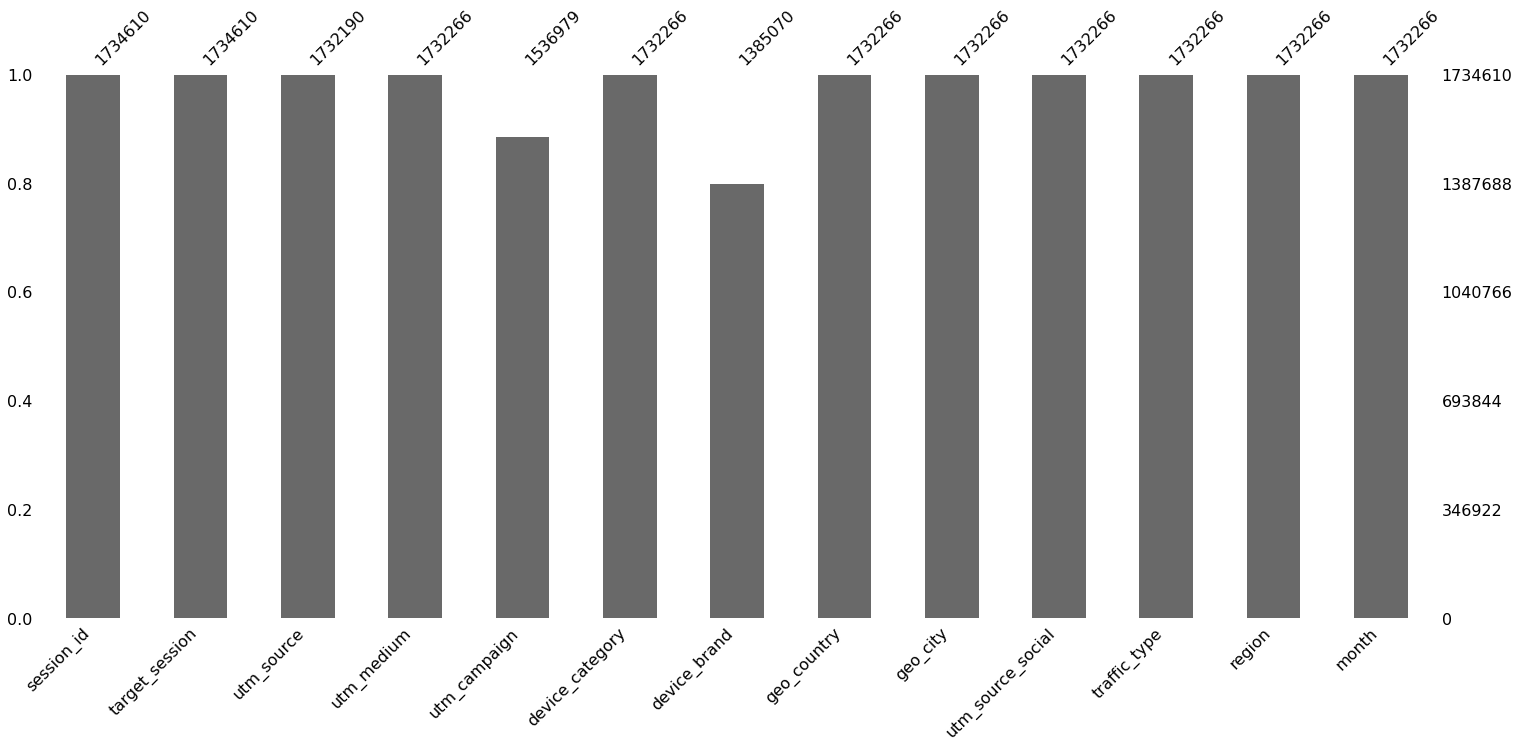

In [7]:
msno.bar(df)

In [8]:
missing_values = ((df.isna().sum()/len(df)) * 100).sort_values(ascending=False)
print('Процент пропущенных значений:')
missing_values

Процент пропущенных значений:


device_brand         20.150927
utm_campaign         11.393397
utm_source            0.139513
utm_medium            0.135131
device_category       0.135131
geo_country           0.135131
geo_city              0.135131
utm_source_social     0.135131
traffic_type          0.135131
region                0.135131
month                 0.135131
session_id            0.000000
target_session        0.000000
dtype: float64

In [9]:
print('Количество пропущенных значений:')
df.isnull().sum().sort_values(ascending=False)

Количество пропущенных значений:


device_brand         349540
utm_campaign         197631
utm_source             2420
utm_medium             2344
device_category        2344
geo_country            2344
geo_city               2344
utm_source_social      2344
traffic_type           2344
region                 2344
month                  2344
session_id                0
target_session            0
dtype: int64

Поскольку ряд признаков содержит одинаково незначительное количество пропусков, а именно **0.135131% или 2344**, можно предположить, что какие-то строки не заполнены сразу по нескольким признакам. Если это так, то эти строки можно безболезненно полностью удалить. 

In [11]:
mask = df.utm_source.isna() \
       & df.utm_medium.isna() \
       & df.device_category.isna() \
       & df.geo_country.isna() \
       & df.geo_city.isna() \
       & df.utm_source_social.isna() \
       & df.traffic_type.isna() \
       & df.region.isna() \
       & df.month.isna()

indx_to_drop = df[mask].index.tolist()
print('Количество строк для удаления: ', len(indx_to_drop))

Количество строк для удаления:  2344


In [12]:
df.drop(indx_to_drop, inplace=True)

In [13]:
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
print('Процент пропущенных значений:')
missing_values[missing_values.values > 0]

Процент пропущенных значений:


device_brand    20.042880
utm_campaign    11.273500
utm_source       0.004387
dtype: float64

Ввиду незначительного количества оставшиеся пропущенные строки в **utm_source** будут удалены.

Пропущенные значения будут заменены:
- в колонке **device_brand** на **(not set)**:
- в колонке **utm_campaign** на наиболее часто встречающиеся.  

In [14]:
source_drop = df.utm_source.isna()
indx_to_drop = df[source_drop].index.tolist()
print('Количество строк для удаления: ', len(indx_to_drop))

Количество строк для удаления:  76


In [15]:
df.drop(indx_to_drop, inplace=True)

In [16]:
df.device_brand = df.device_brand.fillna('(not set)')

In [17]:
df['utm_campaign'].describe()

count                  1536903
unique                     406
top       LTuZkdKfxRGVceoWkVyg
freq                    422965
Name: utm_campaign, dtype: object

In [18]:
df['utm_campaign'].replace(np.nan, 'LTuZkdKfxRGVceoWkVyg', inplace = True)

In [19]:
print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))

Процент полностью заполненных объектов из всей выборки: 100.0


###### Cохранение подготовленного датасета в csv

In [20]:
df.to_csv('data/df_clear.csv', index=False)

In [2]:
df = pd.read_csv('data/df_clear.csv', low_memory=False)
print(f'Размер выбоpки: {df.shape[0]}, {df.shape[1]}')
df.head()

Размер выбоpки: 1732190, 13


session_id  target_session  \
0  1000009318903347362.1632663668.1632663668               0   
1  1000010177899156286.1635013443.1635013443               0   
2  1000013386240115915.1635402956.1635402956               0   
3  1000017303238376207.1623489300.1623489300               0   
4  1000020580299877109.1624943350.1624943350               0   

             utm_source utm_medium          utm_campaign device_category  \
0  MvfHsxITijuriZxsqZqt        cpm  FTjNLDyTrXaWYgZymFkV          mobile   
1  fDLlAcSmythWSCVMvqvL     (none)  LTuZkdKfxRGVceoWkVyg          mobile   
2  ZpYIoDJMcFzVoPFsHGJL     banner  gecBYcKZCPMcVYdSSzKP          mobile   
3  ZpYIoDJMcFzVoPFsHGJL     banner  LEoPHuyFvzoNfnzGgfcd          mobile   
4  fDLlAcSmythWSCVMvqvL     (none)  LTuZkdKfxRGVceoWkVyg          mobile   

  device_brand geo_country    geo_city  utm_source_social traffic_type  \
0      Samsung      Russia  Gelendzhik                1.0         paid   
1      Samsung      Russia    Voronezh                0.0      organic   
2      Samsung      Russia   Cherkessk                0.0         paid   
3       Realme      Russia     Irkutsk                0.0         paid   
4        Apple      Russia      Moscow                0.0      organic   

         region  month  
0  Other_Russia    9.0  
1  Other_Russia   10.0  
2  Other_Russia   10.0  
3  Other_Russia    6.0  
4        Moscow    6.0

**Описание атрибутов объединённого датасета:**
- session_id — ID визита;
- target_session — целевое действие;
- utm_source — канал привлечения;
- utm_medium — тип привлечения;
- utm_campaign — рекламная кампания;
- device_category — тип устройства;
- device_brand — марка устройства;
- geo_country — страна, из которой осуществлялся визит;
- geo_city — город, из которого осуществлялся визит;
- utm_source_social — принадлежность к социальной сети;
- traffic_type — тип трафика;
- region - регион, из которого осуществлялся визит;
- month - месяц визита. 


# 3. Проверка гипотез

## 3.1 Гипотеза 1. Органический трафик не отличается от платного с точки зрения CR (Conversion Rate) в целевые события.

##### Подготовка выборок

In [4]:
target_traffic = df.groupby(['traffic_type'],as_index=False).agg({'target_session':['sum','count']})                                             
target_traffic['CR'] = round(target_traffic['target_session','sum'] / target_traffic['target_session','count'] * 100, 2)
print('Обобщенные данные по типам трафика:')
target_traffic

Обобщенные данные по типам трафика:


traffic_type target_session             CR
                          sum    count      
0      organic          20812   468920  4.44
1         paid          29497  1263270  2.33

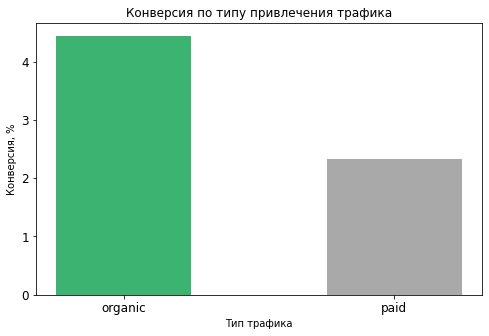

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.bar( target_traffic.traffic_type, target_traffic.CR, width=0.5, color=['mediumseagreen', 'darkgrey'])

ax.set_xlabel('Тип трафика')
ax.set_ylabel('Конверсия, %')
ax.set_title('Конверсия по типу привлечения трафика')
ax.tick_params(axis='both', labelsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

In [6]:
diff_CR = target_traffic.CR[0] - target_traffic.CR[1]
print(f'Конверсия органического трафика выше конверсии платного трафика на {diff_CR:.2f} %')

Конверсия органического трафика выше конверсии платного трафика на 2.11 %


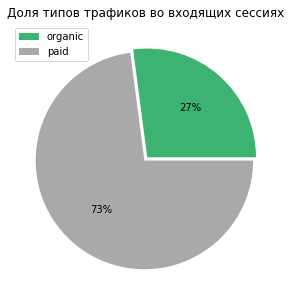

In [7]:
explode = (0.02, 0.02)
colors = ['mediumseagreen', 'darkgrey']
plt.figure(figsize=(8, 5))
plt.pie(target_traffic['target_session','count'], 
        labels=target_traffic['traffic_type'], labeldistance=None, autopct = '%1.0f%%', colors=colors, explode=explode)
plt.title("Доля типов трафиков во входящих сессиях")
plt.legend()
plt.show();

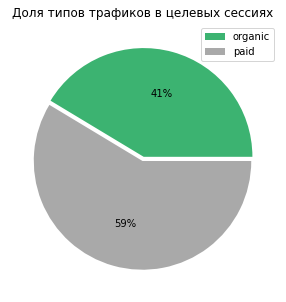

In [8]:
explode = (0.02, 0.02)
colors = ['mediumseagreen', 'darkgrey']
plt.figure(figsize=(8, 5))
plt.pie(target_traffic['target_session','sum'], 
        labels=target_traffic['traffic_type'], labeldistance=None, autopct = '%1.0f%%', colors=colors, explode=explode)
plt.title("Доля типов трафиков в целевых сессиях")
plt.legend()
plt.show();

##### Проверка на номальность распределения

In [9]:
organic = df[df.traffic_type == 'organic'].groupby(['month', 'utm_medium']).agg({'target_session':['sum','count']}) 
organic['CR'] = round(organic['target_session','sum'] / organic['target_session','count'] * 100, 2)

paid = df[df.traffic_type == 'paid'].groupby(['month', 'utm_medium']).agg({'target_session':['sum','count']}) 
paid['CR'] = round(paid['target_session','sum'] / paid['target_session','count'] * 100, 2)

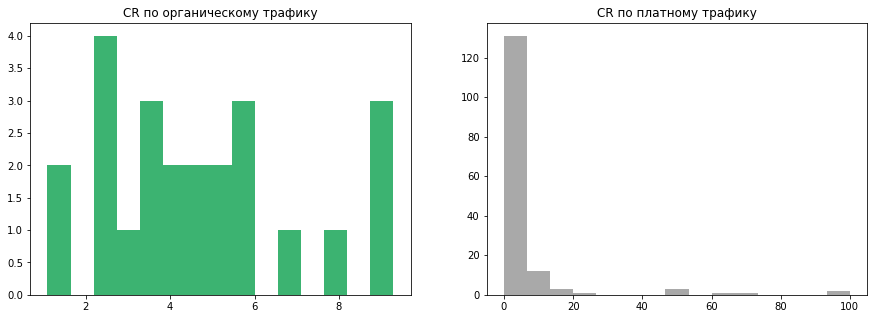

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].hist(organic['CR'], bins=15, color='mediumseagreen')
axs[0].set_title('CR по органическому трафику')
axs[1].hist(paid['CR'],bins=15, color='darkgrey')
axs[1].set_title('CR по платному трафику')
plt.show()

### `Тест Шапиро — Уилка`

In [11]:
print('Выборка органического трафика соответствует нормальному распределению - pvalue > 0.05:\n', stats.shapiro(organic.CR))

Выборка органического трафика соответствует нормальному распределению - pvalue > 0.05:
 ShapiroResult(statistic=0.9308361411094666, pvalue=0.10177450627088547)


In [12]:
print('Выборка платного трафика не соответствует нормальному распределению - pvalue < 0.05:\n', stats.shapiro(paid.CR))

Выборка платного трафика не соответствует нормальному распределению - pvalue < 0.05:
 ShapiroResult(statistic=0.3840903639793396, pvalue=9.277289497502427e-23)


Выборки независимые, так как значения из выборки органического трафика не пересекаются со значениями из платного трафика.

**Итак, поскольку** 
- Данные НЕ РАСПРЕДЕЛЕНЫ НОРМАЛЬНО;
- Выборки НЕЗАВИСИМЫЕ

**используется НЕПАРАМЕТРИЧЕСКИЙ критерий** 

### `U критерий Манна-Уитни`

 - $H_0$ - **CR** (Conversion Rate) органического трафика **не отличается** от CR платного трафика.  
 - $H_1$ - **CR** органического и платного трафиков **отличаются**.  

In [13]:
stats.mannwhitneyu(organic.CR, paid.CR, alternative='greater')

MannwhitneyuResult(statistic=2678.0, pvalue=0.00017156250426884545)

**Вывод:**
    
Т.к. **p-value < 5%**, различия в оценках между видами трафика являются статистически значимыми.

Органический трафик отличается от платного с точки зрения конверсии. Конверсия в целевые события органического трафика выше, платного.

***Данные позволяют отвергнуть нулевую гипотезу и принять альтернативную***.

## 3.2. Гипотеза 2. Трафик с мобильных устройств не отличается от трафика с десктопных устройств с точки зрения CR (Conversion Rate) в целевые события.

##### Подготовка выборок

In [6]:
target_device = df.groupby(['device_category'],as_index=False).agg({'target_session':['sum','count']})                                             
target_device['CR'] = round(target_device['target_session','sum'] / target_device['target_session','count'] * 100, 2)
print('Обобщенные данные по типам устройств:')
target_device

Обобщенные данные по типам устройств:


device_category target_session             CR
                             sum    count      
0         desktop          11510   346843  3.32
1          mobile          38377  1368651  2.80
2          tablet            422    16696  2.53

Поскольку планшеты, строго говоря, тоже являются мобильными устройствами, было решено **объединить 'mobile' и 'tablet'** в одну категорию  

In [7]:
df['is_device'] = df.device_category.apply(lambda x: 'desktop' if x in ['desktop'] else 'mobile')

In [8]:
target_device = df.groupby(['is_device'],as_index=False).agg({'target_session':['sum','count']})                                             
target_device['CR'] = round(target_device['target_session','sum'] / target_device['target_session','count'] * 100, 2)
print('Обобщенные данные по типам устройств:')
target_device

Обобщенные данные по типам устройств:


is_device target_session             CR
                       sum    count      
0   desktop          11510   346843  3.32
1    mobile          38799  1385347  2.80

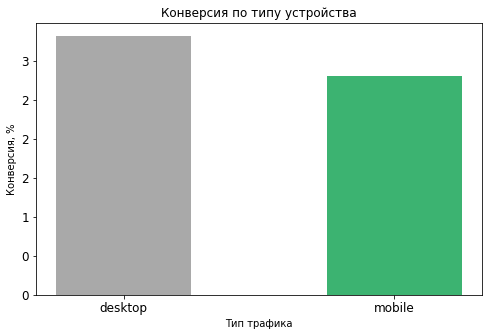

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.bar( target_device.is_device, target_device.CR, width=0.5, color=['darkgrey', 'mediumseagreen'])

ax.set_xlabel('Тип трафика')
ax.set_ylabel('Конверсия, %')
ax.set_title('Конверсия по типу устройства')
ax.tick_params(axis='both', labelsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

In [10]:
diff_CR = target_device.CR[0] - target_device.CR[1]
print(f'Конверсия трафика с десктопных устройств выше конверсии трафика с мобильных устройств на {diff_CR:.2f} %')

Конверсия трафика с десктопных устройств выше конверсии трафика с мобильных устройств на 0.52 %


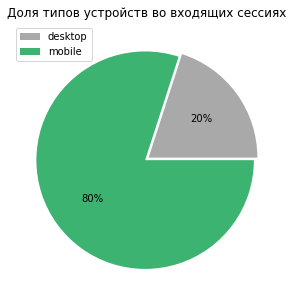

In [11]:
explode = (0.02, 0.02)
colors = ['darkgrey', 'mediumseagreen']
plt.figure(figsize=(8, 5))
plt.pie(target_device['target_session','count'], 
        labels=target_device['is_device'], labeldistance=None, autopct = '%1.0f%%', colors=colors, explode=explode)
plt.title("Доля типов устройств во входящих сессиях")
plt.legend()
plt.show();

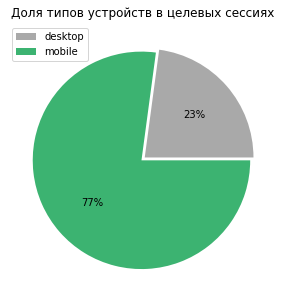

In [12]:
explode = (0.02, 0.02)
colors = ['darkgrey', 'mediumseagreen']
plt.figure(figsize=(8, 5))
plt.pie(target_device['target_session','sum'], 
        labels=target_device['is_device'], labeldistance=None, autopct = '%1.0f%%', colors=colors, explode=explode)
plt.title("Доля типов устройств в целевых сессиях")
plt.legend()
plt.show();

##### Проверка на номальность распределения

In [13]:
mobile = df[df.is_device == 'mobile'].groupby(['month', 'device_brand']).agg({'target_session':['sum','count']}) 
mobile['CR'] = round(mobile['target_session','sum'] / mobile['target_session','count'] * 100, 2)

In [14]:
desktop = df[df.is_device == 'desktop'].groupby(['month', 'device_brand']).agg({'target_session':['sum','count']}) 
desktop['CR'] = round(desktop['target_session','sum'] / desktop['target_session','count'] * 100, 2)

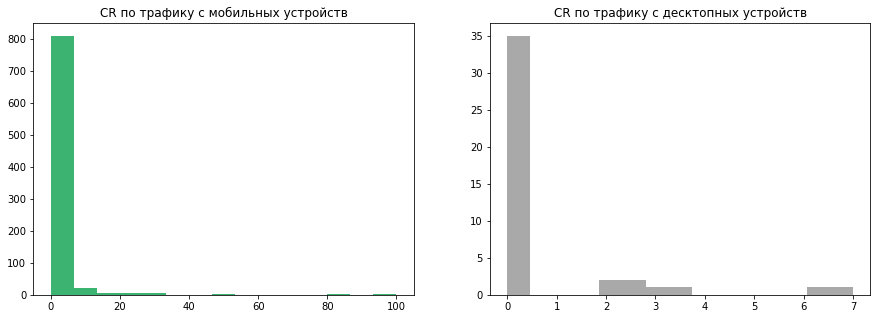

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].hist(mobile['CR'], bins=15, color='mediumseagreen')
axs[0].set_title('CR по трафику c мобильных устройств')
axs[1].hist(desktop['CR'],bins=15, color='darkgrey')
axs[1].set_title('CR по трафику с десктопных устройств')
plt.show()

### `Тест Шапиро — Уилка`

In [16]:
print('Выборка трафика с мобильныx устройств не соответствует нормальному распределению - pvalue < 0.05:\n', 
      stats.shapiro(mobile.CR))

Выборка трафика с мобильныx устройств не соответствует нормальному распределению - pvalue < 0.05:
 ShapiroResult(statistic=0.24335289001464844, pvalue=0.0)


In [17]:
print('Выборка трафика с десктопных устройств не соответствует нормальному распределению - pvalue < 0.05:\n', 
      stats.shapiro(desktop.CR))

Выборка трафика с десктопных устройств не соответствует нормальному распределению - pvalue < 0.05:
 ShapiroResult(statistic=0.4795688986778259, pvalue=3.771108425532077e-11)


- Данные НЕ РАСПРЕДЕЛЕНЫ НОРМАЛЬНО;
- Выборки НЕЗАВИСИМЫЕ (значения из выборки десктопных устройств не пересекаются со значениями из выборки мобильных устройств.)

**используется НЕПАРАМЕТРИЧЕСКИЙ критерий** 

### `U критерий Манна-Уитни`

 - $H_0$ - Трафик с мобильных устройств **не отличается** от трафика с десктопных устройств с точки зрения **CR** в целевые события.  
 - $H_1$ - **CR** мобильного и десктопного трафиков **отличаются**.  

In [18]:
stats.mannwhitneyu(mobile.CR, desktop.CR)

MannwhitneyuResult(statistic=21238.5, pvalue=0.03917103579239013)

**Вывод:**
    
Различия в оценках между типами устройств являются статистически значимыми, т.к. ***p_value*** < **5%**.

Трафик с мобильных устройств отличается от трафика с десктопных устройств с точки зрения конверсии. Конверсия в целевые события трафика с мобильных устройств выше конверсии в целевые события трафика с десктопных устройств.

***Данные позволяют отвергнуть нулевую гипотезу и принять альтернативную***.

## 3.3. Гипотеза 3. Трафик из городов присутствия (Москва и область, Санкт-Петербург) не отличается от трафика из иных регионов с точки зрения CR (Conversion Rate) в целевые события.

##### Подготовка выборок

In [26]:
target_region = df.groupby(['region']).agg({'target_session':['sum','count']})
target_region['CR'] = round(target_region['target_session','sum'] / target_region['target_session','count'] * 100, 2)
print('Обобщенные данные по регионам:')
target_region

Обобщенные данные по регионам:


target_session            CR
                            sum   count      
region                                       
(not set)                   227    7542  3.01
Moscow                    23625  750873  3.15
Moscow_region              3011   98496  3.06
Other_Russia              15402  554579  2.78
Other_countries             931   42301  2.20
Saint Petersburg           7113  278399  2.55

Поскольку, в проверке нуждается гипотеза об отличии трафиков из городов присутствия и из иных регионов, рационально  **объединить 'Moscow', 'Moscow_region'и 'Saint Petersburg'** в одну группу, а остальные значения - в другую группу.     

In [27]:
df['is_region'] = df.region.\
                  apply(lambda x:'presence_city' if x in ['Moscow', 'Moscow_region', 'Saint Petersburg' ] else 'other')

In [28]:
target_region = df.groupby(['is_region'],as_index=False).agg({'target_session':['sum','count']})                                             
target_region['CR'] = round(target_region['target_session','sum'] / target_region['target_session','count'] * 100, 2)
print('Обобщенные данные по типам устройств:')
target_region

Обобщенные данные по типам устройств:


is_region target_session             CR
                            sum    count      
0          other          16560   604422  2.74
1  presence_city          33749  1127768  2.99

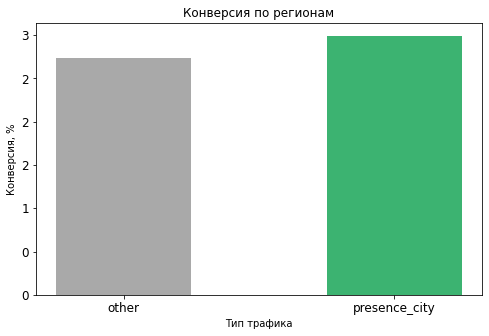

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.bar( target_region.is_region, target_region.CR, width=0.5, color=['darkgrey', 'mediumseagreen'])

ax.set_xlabel('Тип трафика')
ax.set_ylabel('Конверсия, %')
ax.set_title('Конверсия по регионам')
ax.tick_params(axis='both', labelsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

In [30]:
diff_CR = target_region.CR[1] - target_region.CR[0]
print(f'Конверсия трафика из городов присутствия (Москвы, МО, Санкт-Петербурга) выше конверсии трафика из других регионов на: {diff_CR:.2f} %')

Конверсия трафика из городов присутствия (Москвы, МО, Санкт-Петербурга) выше конверсии трафика из других регионов на: 0.25 %


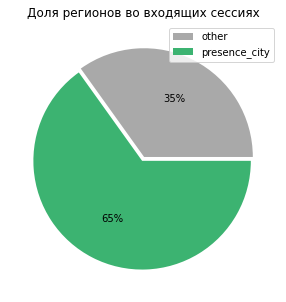

In [31]:
explode = (0.02, 0.02)
colors = ['darkgrey', 'mediumseagreen']
plt.figure(figsize=(8, 5))
plt.pie(target_region['target_session','count'], 
        labels=target_region['is_region'], labeldistance=None, autopct = '%1.0f%%', colors=colors, explode=explode)
plt.title("Доля регионов во входящих сессиях")
plt.legend()
plt.show();

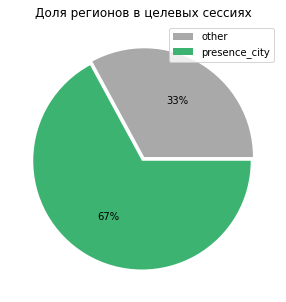

In [32]:
explode = (0.02, 0.02)
colors = ['darkgrey', 'mediumseagreen']
plt.figure(figsize=(8, 5))
plt.pie(target_region['target_session','sum'], 
        labels=target_region['is_region'], labeldistance=None, autopct = '%1.0f%%', colors=colors, explode=explode)
plt.title("Доля регионов в целевых сессиях")
plt.legend()
plt.show();

##### Проверка на номальность распределения

In [33]:
presence_city = df[df.is_region == 'presence_city'].groupby(['month', 'geo_city']).agg({'target_session':['sum','count']}) 
presence_city['CR'] = round(presence_city['target_session','sum'] / presence_city['target_session','count'] * 100, 2)

other_city = df[df.is_region == 'other'].groupby(['month', 'geo_city']).agg({'target_session':['sum','count']}) 
other_city['CR'] = round(other_city['target_session','sum'] / other_city['target_session','count'] * 100, 2)

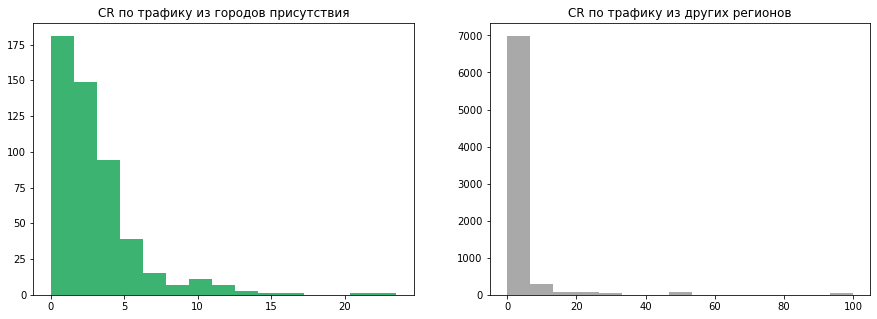

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].hist(presence_city['CR'], bins=15, color='mediumseagreen')
axs[0].set_title('CR по трафику из городов присутствия')
axs[1].hist(other_city['CR'],bins=15, color='darkgrey')
axs[1].set_title('CR по трафику из других регионов')
plt.show()

### `Тест Шапиро — Уилка`

In [35]:
print('Выборка трафика из городов присутствия не соответствует нормальному распределению - pvalue < 0.05:\n', 
      stats.shapiro(presence_city.CR))

Выборка трафика из городов присутствия не соответствует нормальному распределению - pvalue < 0.05:
 ShapiroResult(statistic=0.7998328804969788, pvalue=1.3310905620966897e-24)


In [36]:
print('Выборка трафика из других регионов не соответствует нормальному распределению - pvalue < 0.05:\n', 
      stats.shapiro(other_city.CR))

Выборка трафика из других регионов не соответствует нормальному распределению - pvalue < 0.05:
 ShapiroResult(statistic=0.2704535722732544, pvalue=0.0)


- Данные НЕ РАСПРЕДЕЛЕНЫ НОРМАЛЬНО;
- Выборки НЕЗАВИСИМЫЕ (значения из выборки городов присутствия не пересекаются со значениями выборки дугих регионов.)

**используется НЕПАРАМЕТРИЧЕСКИЙ критерий** 

### `U критерий Манна-Уитни`

- $H_0$ - Трафик из **городов присутствия** ***не отличается*** от трафика из **иных регионов** с точки зрения CR в целевые события.
- $H_1$ - **CR** в целевые события от трафика из **городов присутствия и иных регионов** ***отличаются***.  

In [37]:
stats.mannwhitneyu(target_region.CR[1], target_region.CR[0], alternative='greater')

MannwhitneyuResult(statistic=1.0, pvalue=0.5)

**Вывод:**
    
Различия в оценках между видами трафика не являются статистически значимыми (***pvalue > 0.05***)

Трафик из Москвы и Санкт-Петербурга **не отличается** от трафика из других регионов с точки зрения CR.
    
***Данные НЕ позволяют отвергнуть нулевую гипотезу и принять альтернативную***    

# 4. Ответы на вопросы продуктовой команды

## 4.1 Из каких источников / кампаний / устройств / локаций к нам идёт самый целевой трафик (и с точки зрения объёма трафика, и с точки зрения CR)?

### 4.1.1 Из каких источников идёт самый целевой трафик?

### `Источники привлечения в общем трафике`

In [38]:
df.head(3)

session_id  target_session  \
0  1000009318903347362.1632663668.1632663668               0   
1  1000010177899156286.1635013443.1635013443               0   
2  1000013386240115915.1635402956.1635402956               0   

             utm_source utm_medium          utm_campaign device_category  \
0  MvfHsxITijuriZxsqZqt        cpm  FTjNLDyTrXaWYgZymFkV          mobile   
1  fDLlAcSmythWSCVMvqvL     (none)  LTuZkdKfxRGVceoWkVyg          mobile   
2  ZpYIoDJMcFzVoPFsHGJL     banner  gecBYcKZCPMcVYdSSzKP          mobile   

  device_brand geo_country    geo_city  utm_source_social traffic_type  \
0      Samsung      Russia  Gelendzhik                1.0         paid   
1      Samsung      Russia    Voronezh                0.0      organic   
2      Samsung      Russia   Cherkessk                0.0         paid   

         region  month is_device is_region  
0  Other_Russia    9.0    mobile     other  
1  Other_Russia   10.0    mobile     other  
2  Other_Russia   10.0    mobile     other

In [39]:
source_month = df.groupby(['month', 'utm_source'],as_index=False).agg({'target_session':['sum','count']}) 
source_month.columns = ['_'.join(column).rstrip('_') for column in source_month.columns.values]
source_month = source_month.rename(columns={'target_session_sum':'target_sessions',
                                            'target_session_count':'all_sessions'})
source_month['CR'] = round(source_month['target_sessions'] / source_month['all_sessions'] * 100, 2)
print('Обобщенные данные каналов привлечения по месяцам:')
source_month.head()

Обобщенные данные каналов привлечения по месяцам:


month            utm_source  target_sessions  all_sessions     CR
0    5.0  BHcvLfOaCWvWTykYqHVe              114          1526   7.47
1    5.0  BKeImrJuRDZcHiSSTdzm               57           410  13.90
2    5.0  BellrslNBZQZaIxVFGXJ                0             1   0.00
3    5.0  CgsxHpdTmXHvrHqEKRxp                2            62   3.23
4    5.0  CtYDKfzJhMZZOyeUeyMX                0             2   0.00

In [40]:
total_all = source_month.all_sessions.sum()
source_all = source_month.sort_values(by=['all_sessions'], ascending=False)
source_all['%'] = round(source_all['all_sessions'] * 100 / total_all)
all_source = source_all.sort_values(by=['month', 'all_sessions'], ascending=False)
all_source = source_all.groupby(['month'], as_index=False).agg('first')[['month','utm_source', 'CR', '%']]
all_source

month            utm_source    CR     %
0    5.0  fDLlAcSmythWSCVMvqvL  5.69   4.0
1    6.0  fDLlAcSmythWSCVMvqvL  4.54   2.0
2    7.0  ZpYIoDJMcFzVoPFsHGJL  3.23   2.0
3    8.0  kjsLglQLzykiRbcDiGcD  2.99   2.0
4    9.0  kjsLglQLzykiRbcDiGcD  2.36   2.0
5   10.0  ZpYIoDJMcFzVoPFsHGJL  3.14   6.0
6   11.0  ZpYIoDJMcFzVoPFsHGJL  2.80   6.0
7   12.0  ZpYIoDJMcFzVoPFsHGJL  2.07  12.0

In [41]:
all_source['month_sourse'] = all_source['month'].astype(str) + ' / ' + all_source['utm_source']

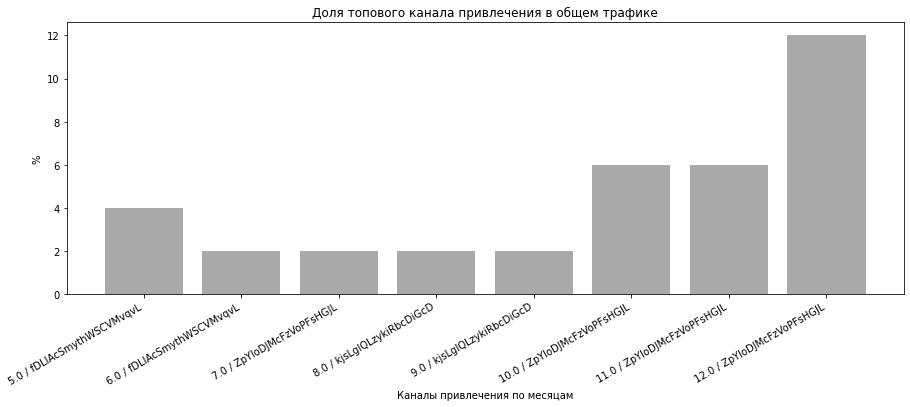

In [42]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(all_source['month_sourse'], all_source['%'], color=['darkgrey'])
plt.xlabel('Каналы привлечения по месяцам')
plt.xticks(ha='right', rotation=30)
plt.ylabel('%')
plt.title('Доля топового канала привлечения в общем трафике');

In [43]:
source = df.groupby(['utm_source'], as_index=False).agg({'target_session':['sum','count']})
source.columns = ['_'.join(column).rstrip('_') for column in source.columns.values]
source = source.rename(columns={'target_session_sum':'sessions_target',
                                'target_session_count':'sessions_all'})
source['CR'] = round(source['sessions_target'] / source['sessions_all'] * 100, 2)

In [44]:
all_total = source.sessions_all.sum()
all_source = source.sort_values(by=['sessions_all'], ascending=False)
all_source['%'] = round(all_source['sessions_all'] * 100 / all_total)
print('Доля каналов привлечения в общем трафике')
all_source.head()

Доля каналов привлечения в общем трафике


utm_source  sessions_target  sessions_all    CR     %
149  ZpYIoDJMcFzVoPFsHGJL            15998        552555  2.90  32.0
176  fDLlAcSmythWSCVMvqvL            10531        277060  3.80  16.0
210  kjsLglQLzykiRbcDiGcD             6293        245178  2.57  14.0
77   MvfHsxITijuriZxsqZqt             2249        175831  1.28  10.0
5    BHcvLfOaCWvWTykYqHVe             3882        110963  3.50   6.0

In [45]:
all_source['%_sourсe'] = all_source['%'].astype(str) + '% ___ ' + all_source['utm_source']

In [46]:
source_top = all_source.iloc[0:10]

Text(0.5, 1.0, 'Распределение визитов по каналу привлечения (топ-10) в общем трафике')

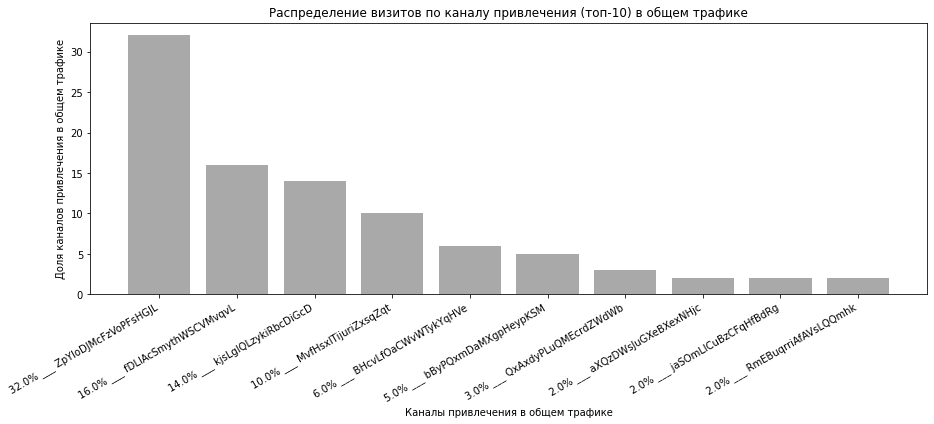

In [47]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(source_top['%_sourсe'], source_top['%'], color=['darkgrey'])
plt.xlabel('Каналы привлечения в общем трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля каналов привлечения в общем трафике')
plt.title('Распределение визитов по каналу привлечения (топ-10) в общем трафике')

In [48]:
all_source['is_utm'] = all_source['%'].apply(lambda x: 'utm_top' if x > 5.0 else 'other')
utm_top = all_source.groupby(['is_utm'],as_index=False).agg({'sessions_all':['sum','count']}) 

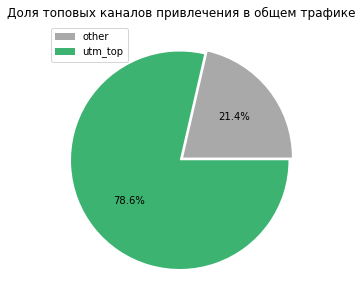

In [49]:
explode = (0.02, 0.02)
colors = ['darkgrey', 'mediumseagreen']
plt.figure(figsize=(8, 5))
plt.pie(utm_top['sessions_all','sum'], 
        labels=utm_top['is_utm'], labeldistance=None, autopct = '%0.1f%%', colors=colors, explode=explode)
plt.title("Доля топовых каналов привлечения в общем трафике")
plt.legend()
plt.show();


**Самыми эффекитвными каналами привлечения в месячном выражении общего трафика были:**
- ***fDLlAcSmythWSCVMvqvL*** - `в мае и июне` 
-   ***kjsLglQLzykiRbcDiGcD*** - `в августе и сентябре`
- ***ZpYIoDJMcFzVoPFsHGJL*** - `в июле, октябре, ноябре и декабре`

Список ***каналов прилечения***, доля которых составляет **более `5%`** от **общего трафика**, выглядит следующим образом:

- ZpYIoDJMcFzVoPFsHGJL - 32%
- fDLlAcSmythWSCVMvqvL - 16%
- kjsLglQLzykiRbcDiGcD - 14%
- MvfHsxITijuriZxsqZqt - 10%
- BHcvLfOaCWvWTykYqHVe - 6%


Т.е., на **топовые** каналы привлечения в ***общем трафике*** приходится **`78,6%`**

### `Каналы привлечения в целевом трафике`

In [50]:
total_target = source_month.target_sessions.sum()
source_target = source_month.sort_values(by=['target_sessions'], ascending=False)
source_target['%'] = round(source_all['target_sessions'] * 100 / total_target)
target_source = source_target.sort_values(by=['month', 'target_sessions'], ascending=False)
target_source = source_target.groupby(['month'], as_index=False).agg('first')[['month','utm_source', 'CR', '%']]
target_source

month            utm_source    CR    %
0    5.0  fDLlAcSmythWSCVMvqvL  5.69  7.0
1    6.0  fDLlAcSmythWSCVMvqvL  4.54  4.0
2    7.0  ZpYIoDJMcFzVoPFsHGJL  3.23  3.0
3    8.0  ZpYIoDJMcFzVoPFsHGJL  4.47  2.0
4    9.0  ZpYIoDJMcFzVoPFsHGJL  4.28  3.0
5   10.0  ZpYIoDJMcFzVoPFsHGJL  3.14  7.0
6   11.0  ZpYIoDJMcFzVoPFsHGJL  2.80  5.0
7   12.0  ZpYIoDJMcFzVoPFsHGJL  2.07  8.0

In [51]:
target_source['month_sourse'] = target_source['month'].astype(str) + ' / ' + target_source['utm_source']

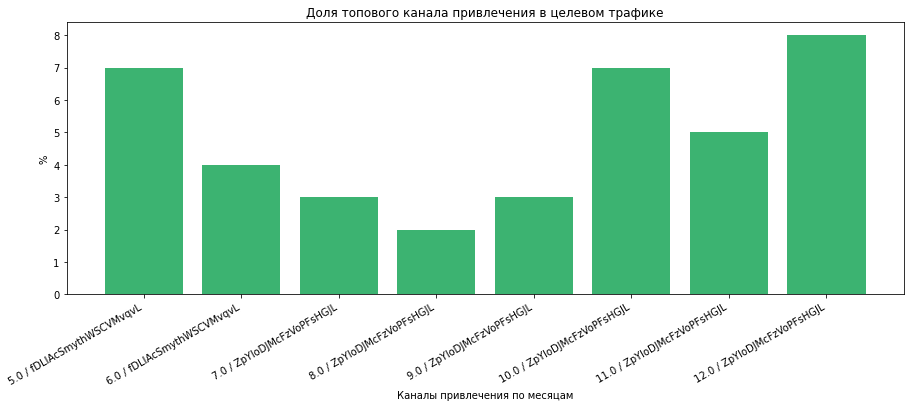

In [52]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(target_source['month_sourse'], target_source['%'], color=['mediumseagreen'])
plt.xlabel('Каналы привлечения по месяцам')
plt.xticks(ha='right', rotation=30)
plt.ylabel('%')
plt.title('Доля топового канала привлечения в целевом трафике');

In [53]:
target_total = source.sessions_target.sum()
target_source = source.sort_values(by=['sessions_target'], ascending=False)
target_source['%'] = round(all_source['sessions_target'] * 100 / target_total)
print('Доля каналов привлечения в целевых сессиях')
target_source.head(10)

Доля каналов привлечения в целевых сессиях


utm_source  sessions_target  sessions_all     CR     %
149  ZpYIoDJMcFzVoPFsHGJL            15998        552555   2.90  32.0
176  fDLlAcSmythWSCVMvqvL            10531        277060   3.80  21.0
210  kjsLglQLzykiRbcDiGcD             6293        245178   2.57  13.0
156  bByPQxmDaMXgpHeypKSM             5557         90356   6.15  11.0
5    BHcvLfOaCWvWTykYqHVe             3882        110963   3.50   8.0
77   MvfHsxITijuriZxsqZqt             2249        175831   1.28   4.0
153  aXQzDWsJuGXeBXexNHjc             1827         29528   6.19   4.0
96   QxAxdyPLuQMEcrdZWdWb             1404         45267   3.10   3.0
205  jaSOmLICuBzCFqHfBdRg              401         28288   1.42   1.0
232  oZCzWSykfixnjMPDNjSU              260          2585  10.06   1.0

In [54]:
target_source['%_sourсe'] = target_source['%'].astype(str) + '% ___ ' + target_source['utm_source']

Text(0.5, 1.0, 'Распределение целевых визитов по каналу привлечения (топ-10)')

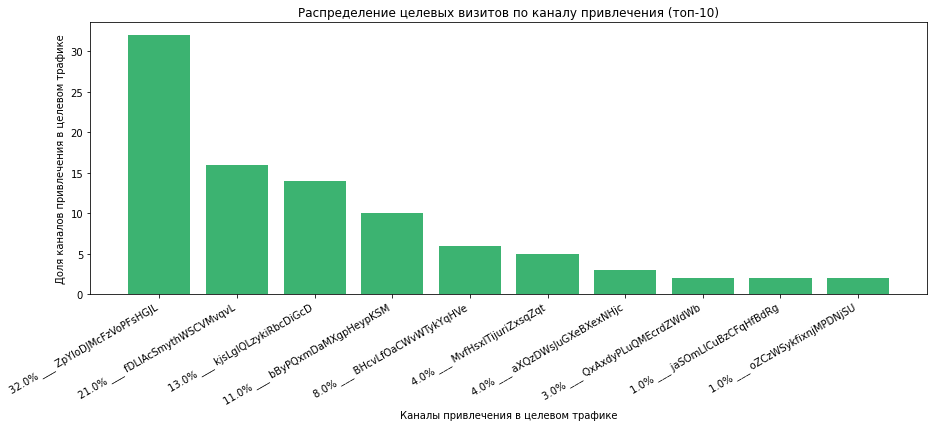

In [55]:
top_target_source = target_source.iloc[0:10]
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(top_target_source['%_sourсe'], source_top['%'], color=['mediumseagreen'])
plt.xlabel('Каналы привлечения в целевом трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля каналов привлечения в целевом трафике')
plt.title('Распределение целевых визитов по каналу привлечения (топ-10)')

In [56]:
target_source['is_utm'] = target_source['%'].apply(lambda x: 'utm_top' if x > 5.0 else 'other')
utm_target_top = target_source.groupby(['is_utm'],as_index=False).agg({'sessions_target':['sum','count']}) 

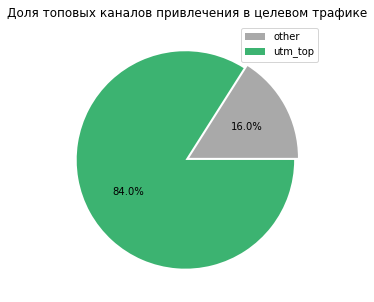

In [57]:
explode = (0.02, 0.02)
colors = ['darkgrey', 'mediumseagreen']
plt.figure(figsize=(8, 5))
plt.pie(utm_target_top['sessions_target','sum'], 
        labels=utm_target_top['is_utm'], labeldistance=None, autopct = '%0.1f%%', colors=colors, explode=explode)
plt.title("Доля топовых каналов привлечения в целевом трафике")
plt.legend()
plt.show();

**Самыми эффективными каналами привлечения в целевом трафике в месячном выражении были:**
- ***fDLlAcSmythWSCVMvqvL*** - `в мае и июне`

- ***ZpYIoDJMcFzVoPFsHGJL*** - `с августа по декабрь`

***Каналы прилечения***, доля которых составляет **более `5%`** от **целевого трафика**:
- ZpYIoDJMcFzVoPFsHGJL - 32%
- fDLlAcSmythWSCVMvqvL - 21%
- kjsLglQLzykiRbcDiGcD - 13%
- MvfHsxITijuriZxsqZqt - 11%
- BHcvLfOaCWvWTykYqHVe - 8%

Таким образом, на **топовые** каналы привлечения в ***целевом трафике*** приходится **`84%`**

In [58]:
source.sort_values(by=['CR'], ascending=False).head(10)

utm_source  sessions_target  sessions_all      CR
144  YpBKcihLLfFjWuxOLfvW                1             1  100.00
177  fJCYsujgSxIHFbOmgDdN                7             8   87.50
134  XzfzEBYZWgSDtJNXOadn                1             2   50.00
16   CqeIpFwJscTsZoYXdHsP                1             2   50.00
274  yxJKymlSGVuKIPTxbysx                1             3   33.33
63   LIWKeifdTCbuNeniIUqm               17            52   32.69
55   JcVHXwVSrnfIuOMMEkrJ                1             4   25.00
196  hONgZhBaHwLGhvJSefNE                1             5   20.00
207  juYouSPHPfKdXivEPJjt                1             5   20.00
194  hIlpdXTVGwzYWIOqvhtN                1             5   20.00

In [59]:
target_CR = source[(source.CR > 2.5) & (source.sessions_target > 1)].sort_values(by=['CR'], ascending=False).head(10)
target_CR['CR_sourсe'] = target_CR['CR'].astype(str) + '% ___ ' + target_source['utm_source']

Text(0.5, 1.0, 'Распределение каналов привлечения (топ-10) с самой высокой конверсией')

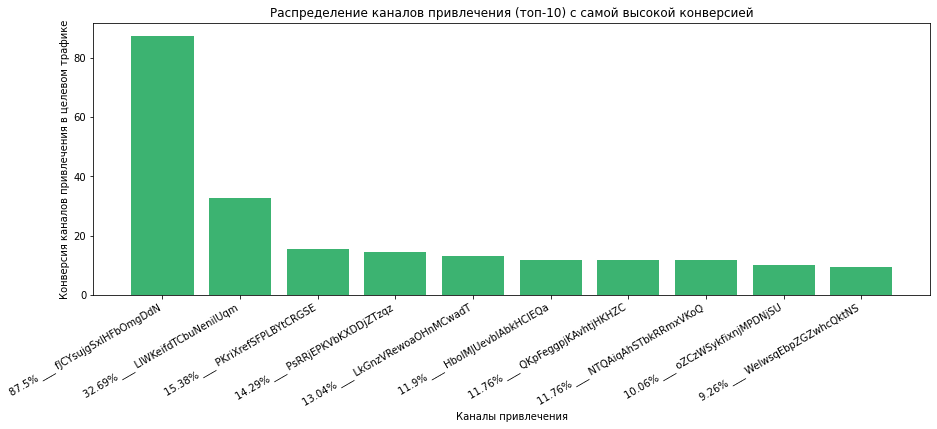

In [60]:
top_target_CR = target_CR.iloc[0:10]
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(top_target_CR['CR_sourсe'], top_target_CR['CR'], color=['mediumseagreen'])
plt.xlabel('Каналы привлечения')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Конверсия каналов привлечения в целевом трафике')
plt.title('Распределение каналов привлечения (топ-10) с самой высокой конверсией')

Самый целевой трафик с точки зрения CR в целевые действия идет из **YpBKcihLLfFjWuxOLfvW** ***(CR - 100%)***. Однако, это значение нельзя считать показательным, поскольку **общее количество сессий = целевому трафику = 1**. Поэтому было решено оставить лишь те источники, посредством которых было совершено `более 1 целевого действия и CR > 2.5%`.

### `Типы привлечения в общем трафике`

In [3]:
medium_month = df.groupby(['month', 'utm_medium'],as_index=False).agg({'target_session':['sum','count']}) 
medium_month.columns = ['_'.join(column).rstrip('_') for column in medium_month.columns.values]
medium_month = medium_month.rename(columns={'target_session_sum':'target_sessions',
                                            'target_session_count':'all_sessions'})
medium_month['CR'] = round(medium_month['target_sessions'] / medium_month['all_sessions'] * 100, 2)
print('Обобщенные данные типов привлечения по месяцам:')
medium_month.head()

Обобщенные данные типов привлечения по месяцам:


month utm_medium  target_sessions  all_sessions     CR
0    5.0     (none)             3761         66077   5.69
1    5.0  (not set)                3             6  50.00
2    5.0     banner               47          1175   4.00
3    5.0  catalogue                0             3   0.00
4    5.0        cpc               33          9110   0.36

In [4]:
total_all_medium = medium_month.all_sessions.sum()
medium_all = medium_month.sort_values(by=['all_sessions'], ascending=False)
medium_all['%'] = round(medium_all['all_sessions'] * 100 / total_all_medium)
all_medium = medium_all.sort_values(by=['month', 'all_sessions'], ascending=False)
all_medium = medium_all.groupby(['month'], as_index=False).agg('first')[['month','utm_medium', 'CR', '%']]
all_medium

month utm_medium    CR     %
0    5.0     (none)  5.69   4.0
1    6.0     (none)  4.54   2.0
2    7.0        cpc  2.33   3.0
3    8.0        cpc  3.23   3.0
4    9.0        cpc  1.88   5.0
5   10.0     banner  3.06   6.0
6   11.0     banner  2.74   6.0
7   12.0     banner  1.97  10.0

In [5]:
all_medium['month_medium'] = all_medium['month'].astype(str) + ' / ' + all_medium['utm_medium']

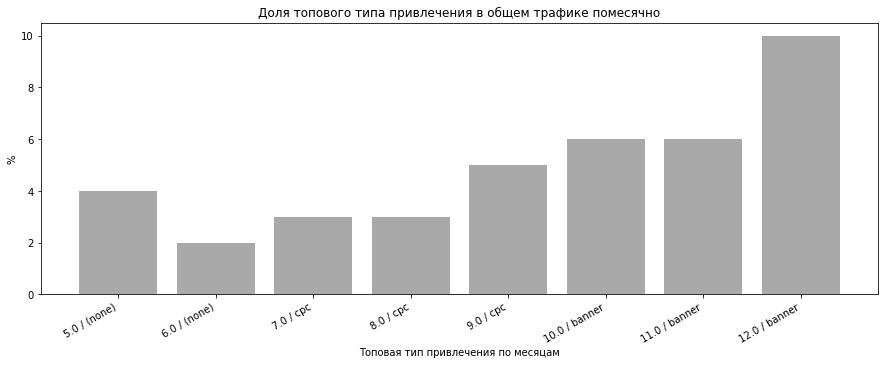

In [6]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(all_medium['month_medium'], all_medium['%'], color=['darkgrey'])
plt.xlabel('Топовая тип привлечения по месяцам')
plt.xticks(ha='right', rotation=30)
plt.ylabel('%')
plt.title('Доля топового типа привлечения в общем трафике помесячно');

In [7]:
medium = df.groupby(['utm_medium'], as_index=False).agg({'target_session':['sum','count']})
medium.columns = ['_'.join(col).rstrip('_') for col in medium.columns.values]
medium = medium.rename(columns={'target_session_sum':'target_sessions',
                                'target_session_count':'all_sessions'})
medium['CR'] = round(medium['target_sessions'] / medium['all_sessions'] * 100, 2)
medium.head()

utm_medium  target_sessions  all_sessions    CR
0     (none)            10531        277060  3.80
1  (not set)               26           378  6.88
2        app               11          1211  0.91
3    article                0            15  0.00
4     banner            15107        525206  2.88

In [8]:
all_total_medium = medium.all_sessions.sum()
all_medium = medium.sort_values(by=['all_sessions'], ascending=False)
all_medium['%'] = round(all_medium['all_sessions'] * 100 / all_total_medium, 2)
print('Доля типов привлечения в общем трафике')
all_medium.head()

Доля типов привлечения в общем трафике


utm_medium  target_sessions  all_sessions    CR      %
4      banner            15107        525206  2.88  30.32
12        cpc             9529        399395  2.39  23.06
0      (none)            10531        277060  3.80  15.99
13        cpm             2519        229791  1.10  13.27
38   referral             8181        136851  5.98   7.90

In [9]:
all_medium['%_medium'] = all_medium['%'].astype(str) + '% ___ ' + all_medium['utm_medium']
medium_top = all_medium.iloc[0:10]

Text(0.5, 1.0, 'Распределение визитов по типам привлечения (топ-10) в общем трафике')

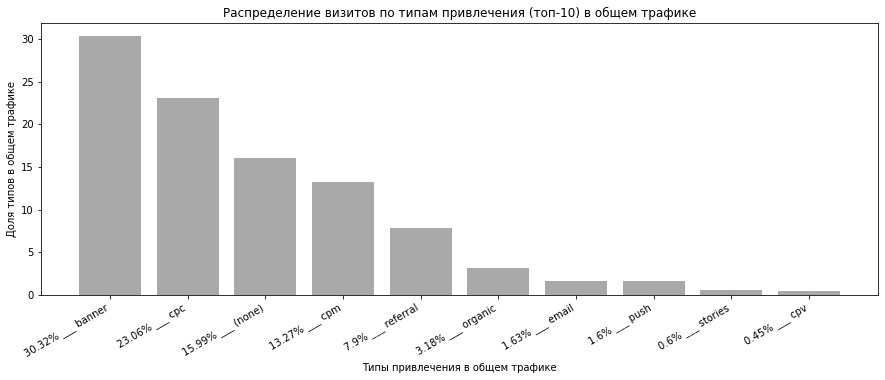

In [10]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(medium_top['%_medium'], medium_top['%'], color=['darkgrey'])
plt.xlabel('Типы привлечения в общем трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля типов в общем трафике')
plt.title('Распределение визитов по типам привлечения (топ-10) в общем трафике')

In [11]:
all_medium['is_medium'] = all_medium['%'].apply(lambda x: 'medium_top' if x > 5.0 else 'other')
top_medium = all_medium.groupby(['is_medium'],as_index=False).agg({'all_sessions':['sum','count']}) 

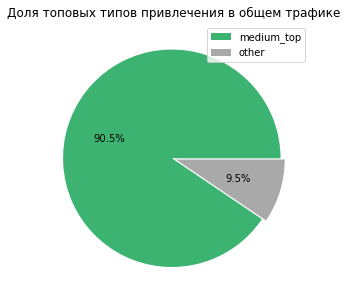

In [12]:
explode = (0.02, 0.02)
colors = ['mediumseagreen','darkgrey']
plt.figure(figsize=(8, 5))
plt.pie(top_medium['all_sessions','sum'], 
        labels=top_medium['is_medium'], labeldistance=None, autopct = '%0.1f%%', colors=colors, explode=explode)
plt.title("Доля топовых типов привлечения в общем трафике")
plt.legend()
plt.show();

**В общем трафике чаще всего клиенты привлекались посредством:**
- ***неизвестных имсточников (none)*** - `в мае и июне` 
-   ***cpc*** - `с июля по сентябрь`
- ***banner*** - `с октября по декабрь`

При этом, самым эффективным типом прилечения по итогам года оказался **banner**. Его доля составила > 30%

Общий список ***источников по типу привлечения*** в **общем трафике**, доля которых составляет **более `5%`**, выглядит следующим образом:

- banner - 30,32%
- cpc - 23,06%
- (none) - 15,99%
- cpm - 13,27%
- referral	- 7,9%

Т.о., на **топовые** типы привлечения в ***общем трафике*** приходится **`90,5%`**

### `Типы привлечения в целевом трафике`

In [13]:
total_target_medium = medium_month.target_sessions.sum()
medium_target_m = medium_month.sort_values(by=['target_sessions'], ascending=False)
medium_target_m['%'] = round(medium_target_m['target_sessions'] * 100 / total_target_medium, 2)
medium_target_m = medium_target_m.sort_values(by=['month', 'target_sessions'], ascending=False)
medium_target_m = medium_target_m.groupby(['month'], as_index=False).agg('first')[['month','utm_medium', 'CR', '%']]
medium_target_m

month utm_medium    CR     %
0    5.0     (none)  5.69  7.48
1    6.0     (none)  4.54  3.87
2    7.0     banner  3.23  2.66
3    8.0        cpc  3.23  2.78
4    9.0     banner  4.24  3.19
5   10.0     banner  3.06  6.25
6   11.0     banner  2.74  5.20
7   12.0     banner  1.97  6.94

In [14]:
medium_target_m['month_medium_target'] = medium_target_m['month'].astype(str) + ' / ' + medium_target_m['utm_medium']

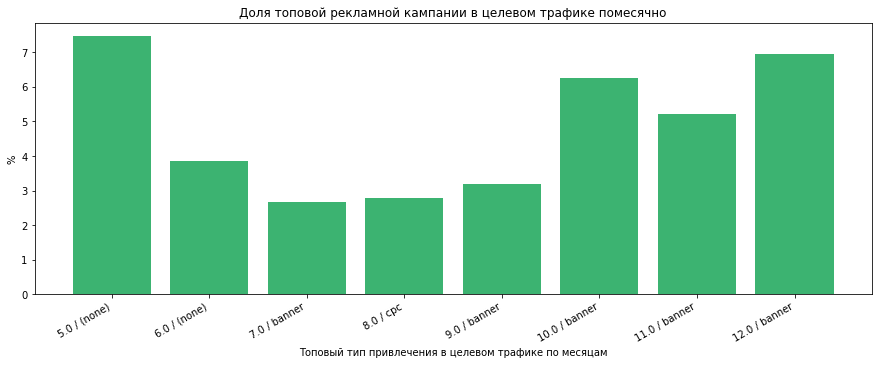

In [15]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(medium_target_m['month_medium_target'], medium_target_m['%'], color=['mediumseagreen'])
plt.xlabel('Топовый тип привлечения в целевом трафике по месяцам')
plt.xticks(ha='right', rotation=30)
plt.ylabel('%')
plt.title('Доля топовой рекламной кампании в целевом трафике помесячно');

In [16]:
total_target_medium = medium.target_sessions.sum()
medium_target = medium.sort_values(by=['target_sessions'], ascending=False)
medium_target['%'] = round(medium_target['target_sessions'] * 100 / total_target_medium, 2)
medium_target.head(10)

utm_medium  target_sessions  all_sessions    CR      %
4            banner            15107        525206  2.88  30.03
0            (none)            10531        277060  3.80  20.93
12              cpc             9529        399395  2.39  18.94
38         referral             8181        136851  5.98  16.26
13              cpm             2519        229791  1.10   5.01
29          organic             2100         55009  3.82   4.17
34             push              840         27710  3.03   1.67
16            email              401         28287  1.42   0.80
40      smartbanner              179          6501  2.75   0.36
5   blogger_channel              162          7731  2.10   0.32

In [17]:
medium_target['%_medium'] = medium_target['%'].astype(str) + '% ___ ' + medium_target['utm_medium']
medium_target_top = medium_target.iloc[0:10]

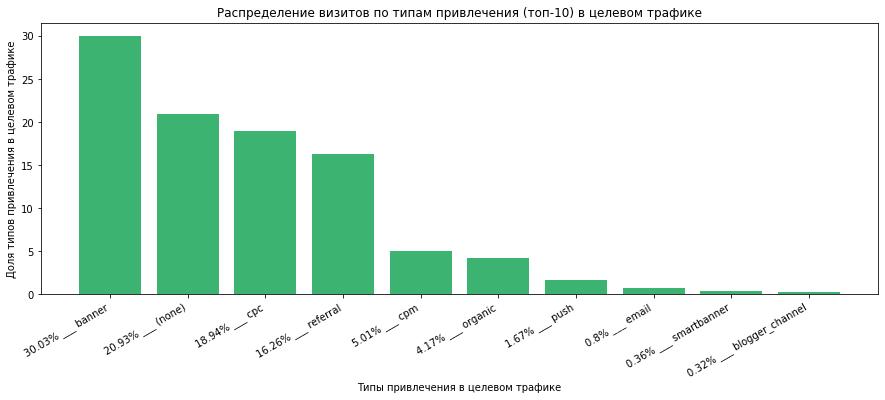

In [18]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(medium_target_top['%_medium'], medium_target_top['%'], color=['mediumseagreen'])
plt.xlabel('Типы привлечения в целевом трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля типов привлечения в целевом трафике')
plt.title('Распределение визитов по типам привлечения (топ-10) в целевом трафике');

In [19]:
medium_target['is_target_medium'] = medium_target['%'].apply(lambda x: 'target_medium_top' if x > 5.0 else 'other')
target_top_medium = medium_target.groupby(['is_target_medium'],as_index=False).agg({'target_sessions':['sum','count']}) 

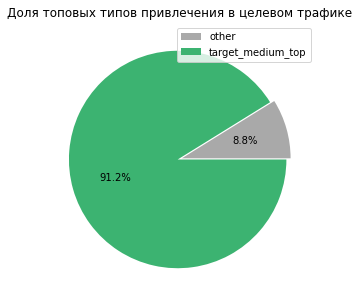

In [20]:
explode = (0.02, 0.02)
colors = ['darkgrey','mediumseagreen']
plt.figure(figsize=(8, 5))
plt.pie(target_top_medium['target_sessions','sum'], 
        labels=target_top_medium['is_target_medium'], labeldistance=None, autopct = '%0.1f%%', colors=colors, explode=explode)
plt.title("Доля топовых типов привлечения в целевом трафике")
plt.legend()
plt.show();

**Самыми эффективными источниками(типами) привлечения целевого трафика были:**
- ***(none)*** - `в мае и в июне` 
- ***cpc*** - `в августе`
- ***banner*** - `в июле и с сентября по декабрь`

Список ***типов привлечения***, доля которых составляет **более `5%`** от **целевого трафика**, выглядит следующим образом:

- banner - 30,03%
- (none) - 20,93%
- cpc - 18,94%
- referral - 16,26%
- cpm - 5,04%

На **топовые** рекламные кампании в ***целевом трафике*** приходится **`91,2%`**

In [21]:
medium.sort_values(by=['CR'], ascending=False).head(10)

utm_medium  target_sessions  all_sessions      CR
15  dom_click                1             1  100.00
23       link               17            52   32.69
43     social                1             5   20.00
20    landing               19           127   14.96
26     medium                1             8   12.50
17     fb_smm                1             8   12.50
42        sms               16           194    8.25
41        smm               87          1194    7.29
1   (not set)               26           378    6.88
38   referral             8181        136851    5.98

In [22]:
medium_target_CR = medium[(medium.CR > 2.5) & (medium.target_sessions > 1)] \
                  .sort_values(by=['CR'], ascending=False).head(10)
medium_target_CR['CR_medium'] = medium_target_CR['CR'].astype(str) + '% ___ ' + medium_target_CR['utm_medium']

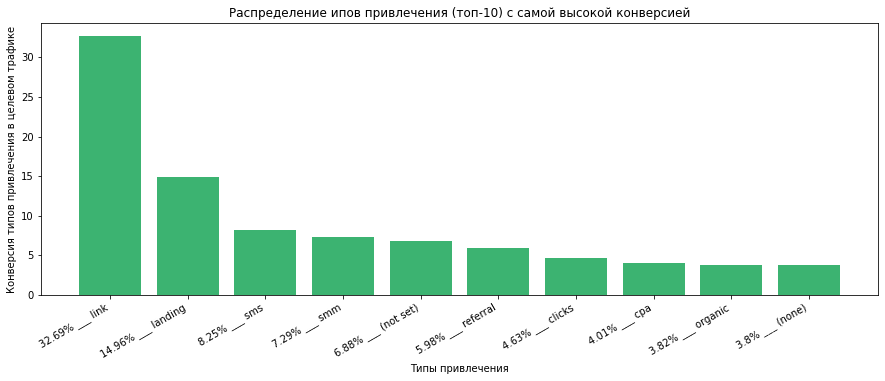

In [26]:
top_medium_target_CR = medium_target_CR.iloc[0:10]
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(top_medium_target_CR['CR_medium'], top_medium_target_CR['CR'], color=['mediumseagreen'])
plt.xlabel('Типы привлечения')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Конверсия типов привлечения в целевом трафике')
plt.title('Распределение ипов привлечения (топ-10) с самой высокой конверсией');

С точки зрения **CR в целевые действия** самым эффективным типом привлечения был ***link*** (CR - 32,7%). 

Значимыми было решено считать лишь показатели тех источников, посредством которых было совершено более 1 целевого действия и CR > 2.5%.

### 4.1.2 Из каких кампаний идёт самый целевой трафик?

### `Рекламные кампании в общем трафике`

In [61]:
campaign_month = df.groupby(['month', 'utm_campaign'],as_index=False).agg({'target_session':['sum','count']}) 
campaign_month.columns = ['_'.join(column).rstrip('_') for column in campaign_month.columns.values]
campaign_month = campaign_month.rename(columns={'target_session_sum':'target_sessions',
                                            'target_session_count':'all_sessions'})
campaign_month['CR'] = round(campaign_month['target_sessions'] / campaign_month['all_sessions'] * 100, 2)
print('Обобщенные данные рекламных кампаний по месяцам:')
campaign_month.head()

Обобщенные данные рекламных кампаний по месяцам:


month          utm_campaign  target_sessions  all_sessions   CR
0    5.0  BHcvLfOaCWvWTykYqHVe                0            21  0.0
1    5.0  BKeImrJuRDZcHiSSTdzm                1            20  5.0
2    5.0  HFaOtpcChAlcMuxEAlpu                0             5  0.0
3    5.0  IOQFgDqnjywyYyRldWoF                0             3  0.0
4    5.0  IXTKLknIYjJQZcDSDKPL                0             4  0.0

In [62]:
total_all_campaign = campaign_month.all_sessions.sum()
campaign_all_m = campaign_month.sort_values(by=['all_sessions'], ascending=False)
campaign_all_m['%'] = round(campaign_all_m['all_sessions'] * 100 / total_all_campaign)
all_campaign_m = campaign_all_m.sort_values(by=['month', 'all_sessions'], ascending=False)
all_campaign_m = campaign_all_m.groupby(['month'], as_index=False).agg('first')[['month','utm_campaign', 'CR', '%']]
all_campaign_m

month          utm_campaign    CR    %
0    5.0  LTuZkdKfxRGVceoWkVyg  6.48  6.0
1    6.0  LTuZkdKfxRGVceoWkVyg  5.50  5.0
2    7.0  LTuZkdKfxRGVceoWkVyg  4.06  4.0
3    8.0  LTuZkdKfxRGVceoWkVyg  4.27  4.0
4    9.0  LTuZkdKfxRGVceoWkVyg  3.18  5.0
5   10.0  gecBYcKZCPMcVYdSSzKP  3.17  5.0
6   11.0  LEoPHuyFvzoNfnzGgfcd  2.83  5.0
7   12.0  LEoPHuyFvzoNfnzGgfcd  2.06  9.0

In [63]:
all_campaign_m['month_campaign'] = all_campaign_m['month'].astype(str) + ' / ' + all_campaign_m['utm_campaign']

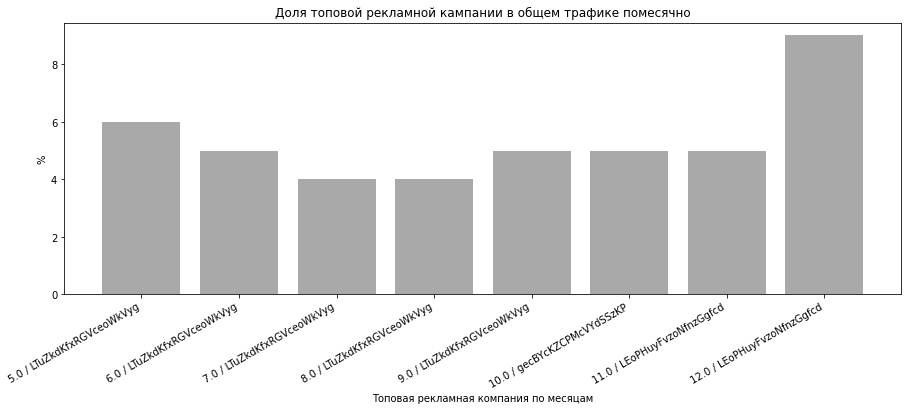

In [64]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(all_campaign_m['month_campaign'], all_campaign_m['%'], color=['darkgrey'])
plt.xlabel('Топовая рекламная компания по месяцам')
plt.xticks(ha='right', rotation=30)
plt.ylabel('%')
plt.title('Доля топовой рекламной кампании в общем трафике помесячно');

In [65]:
campaign = df.groupby(['utm_campaign'], as_index=False).agg({'target_session':['sum','count']})
campaign.columns = ['_'.join(col).rstrip('_') for col in campaign.columns.values]
campaign = campaign.rename(columns={'target_session_sum':'target_sessions',
                                    'target_session_count':'all_sessions'})
campaign['CR'] = round(campaign['target_sessions'] / campaign['all_sessions'] * 100, 2)
campaign.head()

utm_campaign  target_sessions  all_sessions    CR
0  AdtHYglxfCpTpwZeTAuW                0             1  0.00
1  AqudXfUnmXWSDWVGYaXr               10          2272  0.44
2  BAZCuyHZnaPrMGOMrcCQ                1           466  0.21
3  BHcvLfOaCWvWTykYqHVe                0            30  0.00
4  BHqsCPwtnpaQSryaVXya                1            12  8.33

In [66]:
all_total_comp = campaign.all_sessions.sum()
all_campaign = campaign.sort_values(by=['all_sessions'], ascending=False)
all_campaign['%'] = round(all_campaign['all_sessions'] * 100 / all_total_comp, 2)
print('Доля рекламных кампаний в общем трафике')
all_campaign.head()

Доля рекламных кампаний в общем трафике


utm_campaign  target_sessions  all_sessions    CR      %
87   LTuZkdKfxRGVceoWkVyg            26178        618252  4.23  35.69
84   LEoPHuyFvzoNfnzGgfcd             9348        321286  2.91  18.55
39   FTjNLDyTrXaWYgZymFkV             2447        234950  1.04  13.56
255  gecBYcKZCPMcVYdSSzKP             4545        133247  3.41   7.69
192  XHNUiSKKGTEpSAlaVMFQ              401         23750  1.69   1.37

In [67]:
all_campaign['%_campaign'] = all_campaign['%'].astype(str) + '% ___ ' + all_campaign['utm_campaign']
campaign_top = all_campaign.iloc[0:10]

Text(0.5, 1.0, 'Распределение визитов по рекламной кампании (топ-10) в общем трафике')

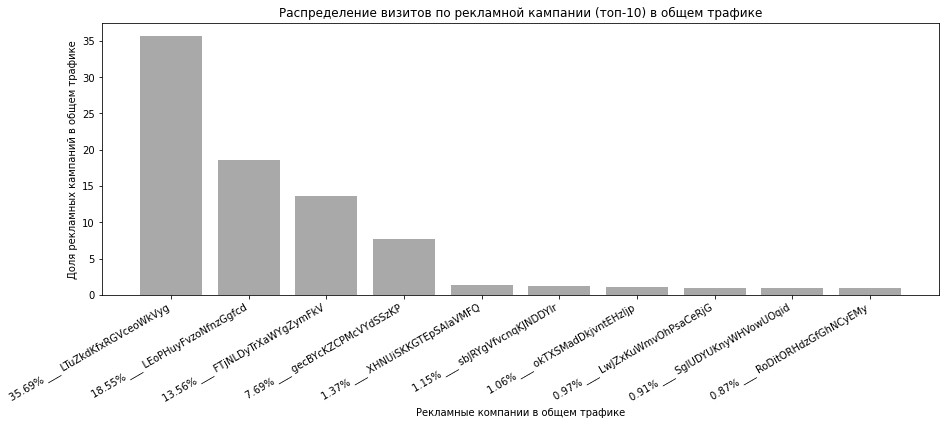

In [68]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(campaign_top['%_campaign'], campaign_top['%'], color=['darkgrey'])
plt.xlabel('Рекламные компании в общем трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля рекламных кампаний в общем трафике')
plt.title('Распределение визитов по рекламной кампании (топ-10) в общем трафике')

In [69]:
all_campaign['is_campaign'] = all_campaign['%'].apply(lambda x: 'campaign_top' if x > 5.0 else 'other')
campaign_top = all_campaign.groupby(['is_campaign'],as_index=False).agg({'all_sessions':['sum','count']}) 

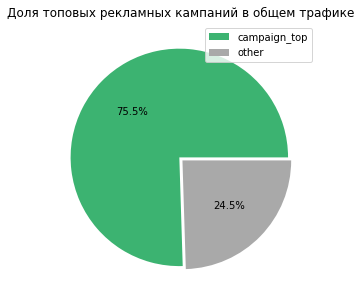

In [70]:
explode = (0.02, 0.02)
colors = ['mediumseagreen','darkgrey']
plt.figure(figsize=(8, 5))
plt.pie(campaign_top['all_sessions','sum'], 
        labels=campaign_top['is_campaign'], labeldistance=None, autopct = '%0.1f%%', colors=colors, explode=explode)
plt.title("Доля топовых рекламных кампаний в общем трафике")
plt.legend()
plt.show();

**Самыми эффекитвными рекламными кампаниями в месячном выражении общего трафика были:**
- ***LTuZkdKfxRGVceoWkVyg*** - `с мая по сентябрь` 
-   ***gecBYcKZCPMcVYdSSzKP*** - `в октябре`
- ***LEoPHuyFvzoNfnzGgfcd*** - `в ноябре и декабре`

Причём, лидировавшая в первые месяцы работы сервиса кампания **LTuZkdKfxRGVceoWkVyg** постепенно теряла свои позиции, в то время как **LEoPHuyFvzoNfnzGgfcd** увеличила к концу года своё присутсвие в общем трафике почти 2 раза.

Список ***рекламных кампаний***, доля которых составляет **более `5%`** от **общего трафика**, выглядит следующим образом:

- LTuZkdKfxRGVceoWkVyg - 36%
- LEoPHuyFvzoNfnzGgfcd - 19%
- FTjNLDyTrXaWYgZymFkV - 14%
- gecBYcKZCPMcVYdSSzKP - 8%

Т.о., на **топовые** рекламные кампании в ***общем трафике*** приходится **`75,5%`**


### `Рекламные кампании в целевом трафике`

In [71]:
total_target_campaign = campaign_month.target_sessions.sum()
campaign_target_m = campaign_month.sort_values(by=['target_sessions'], ascending=False)
campaign_target_m['%'] = round(campaign_target_m['target_sessions'] * 100 / total_target_campaign, 2)
target_campaign_m = campaign_target_m.sort_values(by=['month', 'target_sessions'], ascending=False)
target_campaign_m = campaign_target_m.groupby(['month'], as_index=False).agg('first')[['month','utm_campaign', 'CR', '%']]
target_campaign_m

month          utm_campaign    CR      %
0    5.0  LTuZkdKfxRGVceoWkVyg  6.48  12.63
1    6.0  LTuZkdKfxRGVceoWkVyg  5.50   8.66
2    7.0  LTuZkdKfxRGVceoWkVyg  4.06   5.67
3    8.0  LTuZkdKfxRGVceoWkVyg  4.27   5.97
4    9.0  LTuZkdKfxRGVceoWkVyg  3.18   5.47
5   10.0  gecBYcKZCPMcVYdSSzKP  3.17   5.51
6   11.0  LTuZkdKfxRGVceoWkVyg  3.12   4.73
7   12.0  LEoPHuyFvzoNfnzGgfcd  2.06   6.11

In [72]:
target_campaign_m['month_campaign'] = target_campaign_m['month'].astype(str) + ' / ' + target_campaign_m['utm_campaign']

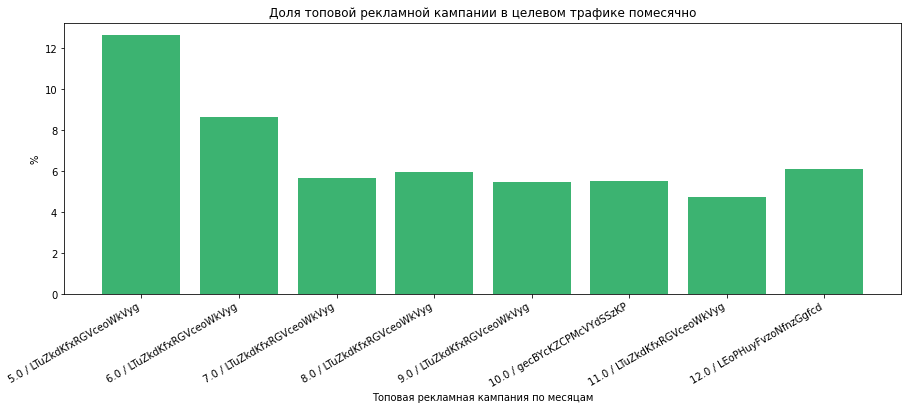

In [73]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(target_campaign_m['month_campaign'], target_campaign_m['%'], color=['mediumseagreen'])
plt.xlabel('Топовая рекламная кампания по месяцам')
plt.xticks(ha='right', rotation=30)
plt.ylabel('%')
plt.title('Доля топовой рекламной кампании в целевом трафике помесячно');

In [74]:
total_target_campaign = campaign.target_sessions.sum()
campaign_target = campaign.sort_values(by=['target_sessions'], ascending=False)
campaign_target['%'] = round(campaign_target['target_sessions'] * 100 / total_target_campaign, 2)
campaign_target.head(10)

utm_campaign  target_sessions  all_sessions    CR      %
87   LTuZkdKfxRGVceoWkVyg            26178        618252  4.23  52.03
84   LEoPHuyFvzoNfnzGgfcd             9348        321286  2.91  18.58
255  gecBYcKZCPMcVYdSSzKP             4545        133247  3.41   9.03
39   FTjNLDyTrXaWYgZymFkV             2447        234950  1.04   4.86
347  sbJRYgVfvcnqKJNDDYIr              575         19942  2.88   1.14
192  XHNUiSKKGTEpSAlaVMFQ              401         23750  1.69   0.80
146  SgIUDYUKnyWHVowUOqid              373         15784  2.36   0.74
92   LwJZxKuWmvOhPsaCeRjG              285         16846  1.69   0.57
404  zxoiLxhuSIFrCeTLQVWZ              270         12234  2.21   0.54
239  eimRuUrNhZLAYcwRrNXu              258          7724  3.34   0.51

In [75]:
campaign_target['%_campaign'] = campaign_target['%'].astype(str) + '% ___ ' + campaign_target['utm_campaign']
campaign_target_top = campaign_target.iloc[0:10]

Text(0.5, 1.0, 'Распределение визитов по рекламной кампании (топ-10) в целевом трафике')

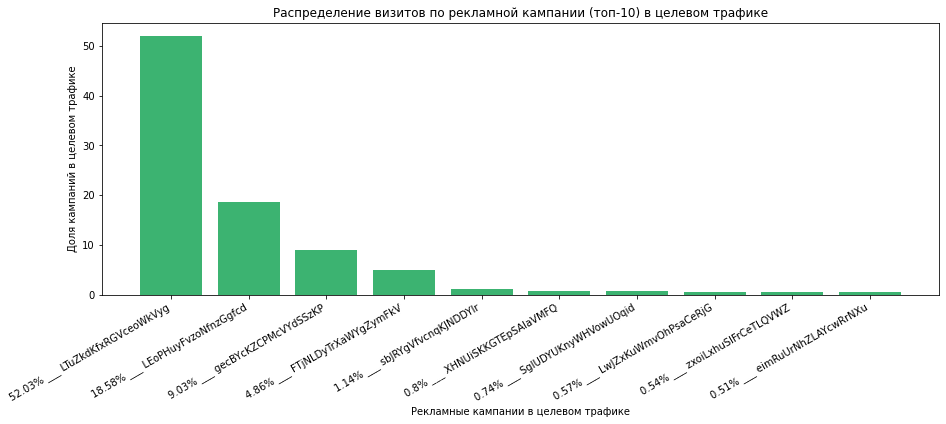

In [76]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(campaign_target_top['%_campaign'], campaign_target_top['%'], color=['mediumseagreen'])
plt.xlabel('Рекламные кампании в целевом трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля кампаний в целевом трафике')
plt.title('Распределение визитов по рекламной кампании (топ-10) в целевом трафике')

In [77]:
campaign_target['is_target_campaign'] = campaign_target['%'].apply(lambda x: 'target_campaign_top' if x > 5.0 else 'other')
campaign_top_target = campaign_target.groupby(['is_target_campaign'],as_index=False).agg({'target_sessions':['sum','count']}) 

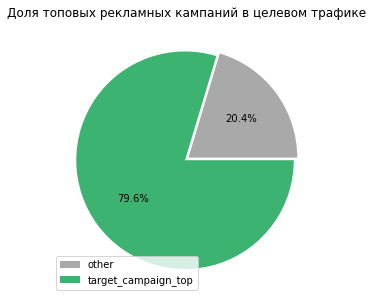

In [78]:
explode = (0.02, 0.02)
colors = ['darkgrey','mediumseagreen']
plt.figure(figsize=(8, 5))
plt.pie(campaign_top_target['target_sessions','sum'], 
        labels=campaign_top_target['is_target_campaign'], labeldistance=None, autopct = '%0.1f%%', colors=colors, explode=explode)
plt.title("Доля топовых рекламных кампаний в целевом трафике")
plt.legend()
plt.show();

**Самыми эффективными рекламными кампаниями в месячном выражении целевого трафика были:**
- ***LTuZkdKfxRGVceoWkVyg*** - `с мая по сентябрь и в ноябре` 
-   ***gecBYcKZCPMcVYdSSzKP*** - `в октябре`
- ***LEoPHuyFvzoNfnzGgfcd*** - `в декабре`

Список ***рекламных кампаний***, доля которых составляет **более `5%`** от **целевого трафика**, выглядит следующим образом:

- LTuZkdKfxRGVceoWkVyg - 52,03%
- LEoPHuyFvzoNfnzGgfcd - 18,58%
- gecBYcKZCPMcVYdSSzKP - 9,03%

Т.о., на **топовые** рекламные кампании в ***целевом трафике*** приходится **`79,6%`**


In [79]:
campaign.sort_values(by=['CR'], ascending=False).head(10)

utm_campaign  target_sessions  all_sessions      CR
95   MHdHrBKQwbDaRalwnlJq                1             1  100.00
69   JkhCpeDGCtTwhwqWLywv                1             1  100.00
58   IRKNegNgOUQLwudzMElF                7             8   87.50
145  SbYAsCvXapXBOIxEKBZs                1             2   50.00
293  lndNIerCYECRQvBTyTye               23            75   30.67
72   KAcUKGokhYlMktQhYKHx                1             4   25.00
150  TOSjvKcurFlcKJijjpYP               10            45   22.22
367  vZqcBrFwxYPoYzJyhYGI                2             9   22.22
17   CqFuKxSYgtGbcafqJwij                1             5   20.00
28   DlOlXJaBJgWQVhgtCeWo                2            11   18.18

In [80]:
campaign_target_CR = campaign[(campaign.CR > 2.5) & (campaign.target_sessions > 1)].sort_values(by=['CR'], ascending=False).head(10)
campaign_target_CR['CR_campaign'] = campaign_target_CR['CR'].astype(str) + '% ___ ' + campaign_target_CR['utm_campaign']

Text(0.5, 1.0, 'Распределение рекламных кампаний (топ-10) с самой высокой конверсией')

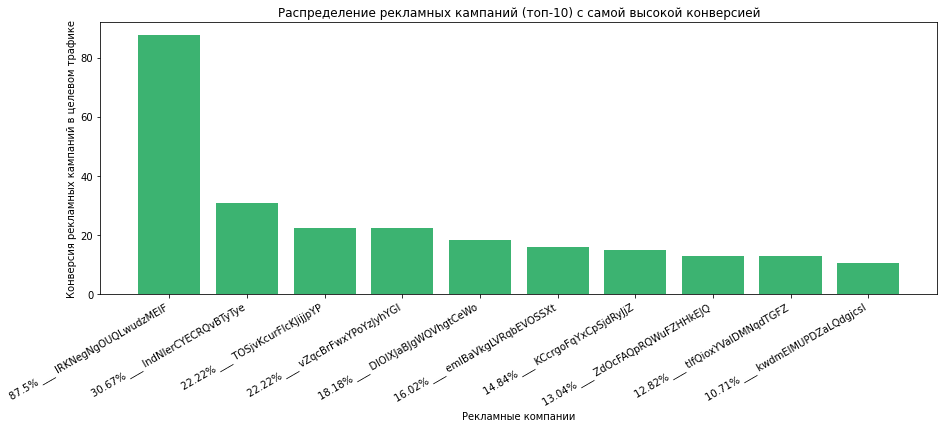

In [81]:
top_camp_target_CR = campaign_target_CR.iloc[0:10]
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(top_camp_target_CR['CR_campaign'], top_camp_target_CR['CR'], color=['mediumseagreen'])
plt.xlabel('Рекламные компании')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Конверсия рекламных кампаний в целевом трафике')
plt.title('Распределение рекламных кампаний (топ-10) с самой высокой конверсией')

С точки зрения CR в целевые действия самой эффективной рекламной кампанией была **IRKNegNgOUQLwudzMElF** ***(CR - 87,5%)***. Поскольку две кампании (**MHdHrBKQwbDaRalwnlJq** и **JkhCpeDGCtTwhwqWLywv**), чьи ***CR = 100%***, не стоит принимать в расчёт, т.к. **общее количество сессий = целевому трафику = 1**. 

Т.о., значимыми было решено считать лишь показатели тех кампании, посредством которых было совершено `более 1 целевого действия и CR > 2.5%`.

### 4.1.3 С каких устройств идёт самый целевой трафик?

### `Устройства в общем трафике`

In [82]:
device_month = df.groupby(['month', 'device_category','device_brand'],as_index=False).agg({'target_session':['sum','count']}) 
device_month.columns = ['_'.join(column).rstrip('_') for column in device_month.columns.values]
device_month = device_month.rename(columns={'target_session_sum':'target_sessions',
                                            'target_session_count':'all_sessions'})
device_month['CR'] = round(device_month['target_sessions'] / device_month['all_sessions'] * 100, 2)
print('Обобщенные данные об устройствах по месяцам:')
device_month.head()

Обобщенные данные об устройствах по месяцам:


month device_category device_brand  target_sessions  all_sessions   CR
0    5.0         desktop    (not set)             2396         34233  7.0
1    5.0         desktop        Apple                0             1  0.0
2    5.0         desktop      Beelink                0             1  0.0
3    5.0         desktop       Huawei                0             9  0.0
4    5.0         desktop      Philips                0             1  0.0

In [90]:
total_all_device = device_month.all_sessions.sum()
device_all_m = device_month.sort_values(by=['all_sessions'], ascending=False)
device_all_m['%'] = round(device_all_m['all_sessions'] * 100 / total_all_device)
all_device_m = device_all_m.sort_values(by=['month', 'all_sessions'], ascending=False)
all_device_m = device_all_m. \
               groupby(['month'], as_index=False). \
               agg('first')[['month','device_category', 'device_brand', 'CR', '%']]
all_device_m

month device_category device_brand    CR    %
0    5.0         desktop    (not set)  7.00  2.0
1    6.0          mobile        Apple  3.58  4.0
2    7.0         desktop    (not set)  2.29  3.0
3    8.0          mobile        Apple  3.54  3.0
4    9.0          mobile        Apple  2.59  4.0
5   10.0          mobile        Apple  2.32  5.0
6   11.0          mobile        Apple  2.42  4.0
7   12.0          mobile        Apple  1.89  5.0

In [91]:
all_device_m['month_device'] = all_device_m['month'].astype(str) + \
                               ' / ' + all_device_m['device_category'] + \
                               '__' + all_device_m['device_brand']

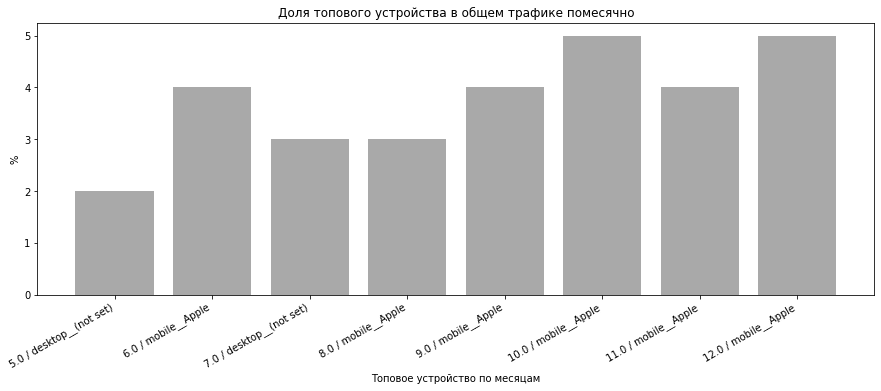

In [92]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(all_device_m['month_device'], all_device_m['%'], color=['darkgrey'])
plt.xlabel('Топовое устройство по месяцам')
plt.xticks(ha='right', rotation=30)
plt.ylabel('%')
plt.title('Доля топового устройства в общем трафике помесячно');

In [93]:
device = df.groupby(['device_category','device_brand'], as_index=False).agg({'target_session':['sum','count']})
device.columns = ['_'.join(col).rstrip('_') for col in device.columns.values]
device = device.rename(columns={'target_session_sum':'target_sessions',
                                'target_session_count':'all_sessions'})
device['CR'] = round(device['target_sessions'] / device['all_sessions'] * 100, 2)
device.head()

device_category device_brand  target_sessions  all_sessions    CR
0         desktop    (not set)            11510        346714  3.32
1         desktop        Apple                0            70  0.00
2         desktop         Asus                0             1  0.00
3         desktop      Beelink                0             2  0.00
4         desktop    Flexymove                0             3  0.00

In [94]:
all_total_device = device.all_sessions.sum()
all_device = device.sort_values(by=['all_sessions'], ascending=False)
all_device['%'] = round(all_device['all_sessions'] * 100 / all_total_device, 2)
print('Доля устройств в общем трафике')
all_device.head()

Доля устройств в общем трафике


device_category device_brand  target_sessions  all_sessions    CR      %
22           mobile        Apple            14326        497673  2.88  28.73
0           desktop    (not set)            11510        346714  3.32  20.02
140          mobile      Samsung             9908        307083  3.23  17.73
177          mobile       Xiaomi             6592        269007  2.45  15.53
75           mobile       Huawei             4446        170586  2.61   9.85

In [95]:
all_device['%_device'] = all_device['%'].astype(str) + \
                        '% ___ ' + all_device['device_category'] + \
                        '__' + all_device['device_brand']
device_top = all_device.iloc[0:10]

Text(0.5, 1.0, 'Распределение визитов топовых устройств (топ-10) в общем трафике')

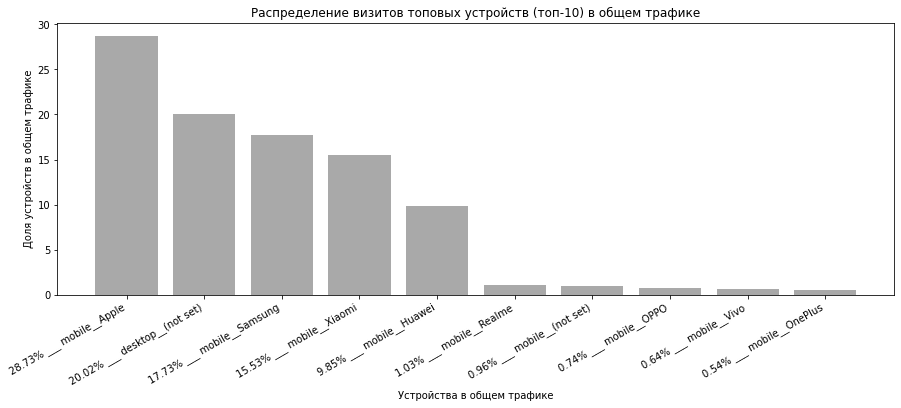

In [96]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(device_top['%_device'], device_top['%'], color=['darkgrey'])
plt.xlabel('Устройства в общем трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля устройств в общем трафике')
plt.title('Распределение визитов топовых устройств (топ-10) в общем трафике')

In [97]:
all_device['is_device'] = all_device['%'].apply(lambda x: 'device_top' if x > 5.0 else 'other')
device_top = all_device.groupby(['is_device'],as_index=False).agg({'all_sessions':['sum','count']})

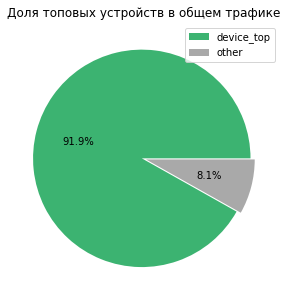

In [98]:
explode = (0.02, 0.02)
colors = ['mediumseagreen','darkgrey']
plt.figure(figsize=(8, 5))
plt.pie(device_top['all_sessions','sum'], 
        labels=device_top['is_device'], labeldistance=None, autopct = '%0.1f%%', colors=colors, explode=explode)
plt.title("Доля топовых устройств в общем трафике")
plt.legend()
plt.show();

**Самыми часто используемыми устройствами,с которых совершались визиты в общем трафике были:**
- ***desktop без бренда*** - `в мае и июле` 
-   ***mobile Apple*** - `в июне и с августа по декабрь`


Список ***устройств***, доля которых составляет **более `5%`** в **общем трафике**, выглядит следующим образом:

- mobile Apple - 28,73%
- desktop без бренда - 20,02%
- mobile Samsung - 17,73%
- mobile Xiaomi - 15,53%
- mobile Huawei - 9,85%

Т.о., на **топовые** устройства в ***общем трафике*** приходится **`91,2%`**. Причем, лишь 20% приходится на десктопные устройства.

### `Устройства в целевом трафике`

In [99]:
total_target_device = device_month.target_sessions.sum()
device_target_m = device_month.sort_values(by=['target_sessions'], ascending=False)
device_target_m['%'] = round(device_target_m['target_sessions'] * 100 / total_target_device, 2)
target_device_m = device_target_m.sort_values(by=['month', 'target_sessions'], ascending=False)
target_device_m = device_target_m.groupby(['month'], as_index=False). \
                                  agg('first')[['month','device_category', 'device_brand', 'CR', '%']]
target_device_m

month device_category device_brand    CR     %
0    5.0         desktop    (not set)  7.00  4.76
1    6.0          mobile        Apple  3.58  4.38
2    7.0          mobile        Apple  2.99  3.07
3    8.0          mobile        Apple  3.54  3.66
4    9.0          mobile        Apple  2.59  3.33
5   10.0          mobile        Apple  2.32  3.70
6   11.0          mobile        Apple  2.42  3.37
7   12.0          mobile      Samsung  2.44  4.05

In [100]:
target_device_m['month_device'] = target_device_m['month'].astype(str) + \
                                 ' / ' + target_device_m['device_category'] + \
                                 '__' + target_device_m['device_brand']

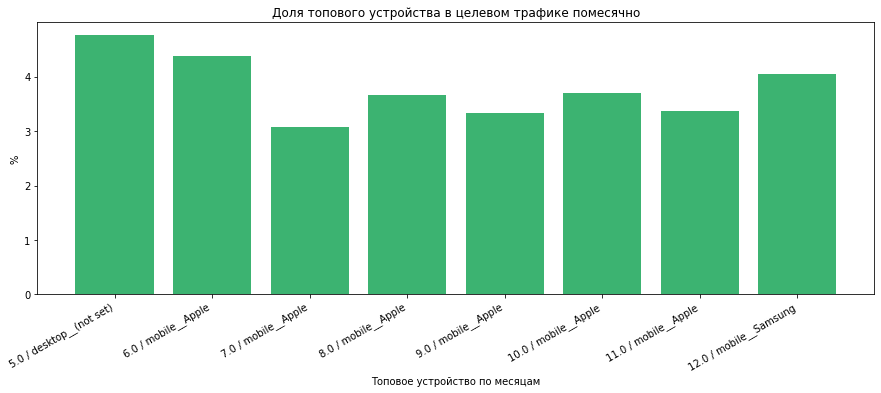

In [101]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(target_device_m['month_device'], target_device_m['%'], color=['mediumseagreen'])
plt.xlabel('Топовое устройство по месяцам')
plt.xticks(ha='right', rotation=30)
plt.ylabel('%')
plt.title('Доля топового устройства в целевом трафике помесячно');

In [102]:
total_target_device = device.target_sessions.sum()
device_target = device.sort_values(by=['target_sessions'], ascending=False)
device_target['%'] = round(device_target['target_sessions'] * 100 / total_target_device, 2)
print('Доля устройств в целевом трафике')
device_target.head(10)

Доля устройств в целевом трафике


device_category device_brand  target_sessions  all_sessions    CR      %
22           mobile        Apple            14326        497673  2.88  28.48
0           desktop    (not set)            11510        346714  3.32  22.88
140          mobile      Samsung             9908        307083  3.23  19.69
177          mobile       Xiaomi             6592        269007  2.45  13.10
75           mobile       Huawei             4446        170586  2.61   8.84
14           mobile    (not set)              459         16573  2.77   0.91
139          mobile       Realme              421         17916  2.35   0.84
122          mobile         OPPO              396         12763  3.10   0.79
166          mobile         Vivo              322         11026  2.92   0.64
118          mobile        Nokia              165          6862  2.40   0.33

In [103]:
device_target['%_device'] = device_target['%'].astype(str) + \
                           '% ___ ' + device_target['device_category'] + \
                           '__' + device_target['device_brand']
device_target_top = device_target.iloc[0:10]

Text(0.5, 1.0, 'Распределение визитов топовых устройств (топ-10) в целевом трафике')

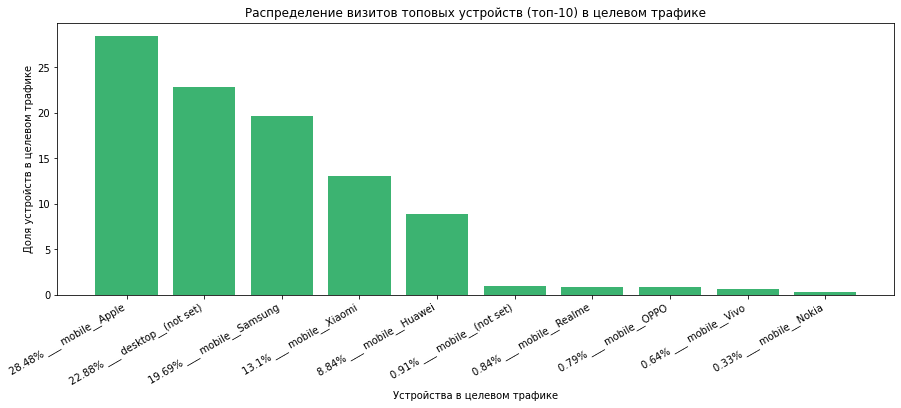

In [104]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(device_target_top['%_device'], device_target_top['%'], color=['mediumseagreen'])
plt.xlabel('Устройства в целевом трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля устройств в целевом трафике')
plt.title('Распределение визитов топовых устройств (топ-10) в целевом трафике')

In [105]:
device_target['is_device'] = device_target['%'].apply(lambda x: 'device_top' if x > 5.0 else 'other')
device_top_target= device_target.groupby(['is_device'],as_index=False).agg({'target_sessions':['sum','count']})

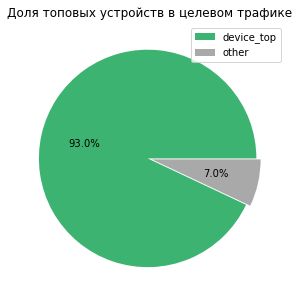

In [106]:
explode = (0.02, 0.02)
colors = ['mediumseagreen','darkgrey']
plt.figure(figsize=(8, 5))
plt.pie(device_top_target['target_sessions','sum'], 
        labels=device_top_target['is_device'], labeldistance=None, autopct = '%0.1f%%', colors=colors, explode=explode)
plt.title("Доля топовых устройств в целевом трафике")
plt.legend()
plt.show();

**Самыми часто используемыми устройствами,с которых совершались визиты в целевом трафике были:**
- ***desktop без бренда*** - `в мае` 
-   ***mobile Apple*** - `с июня по ноябрь`
- ***mobile Samsung*** - `в декабре`

Список ***устройств***, доля которых составляет **более `5%`** в **целевом трафике**, выглядит следующим образом:

- mobile Apple - 28.48%
- desktop без бренда - 22.88%
- mobile Samsung - 19,69%
- mobile Xiaomi - 13.10%
- mobile Huawei - 8,84%

Т.о., на **топовые** устройства в ***целевом трафике*** приходится **`93%`**. Из них почти 23% приходится на десктопные устройства.

In [107]:
device.sort_values(by=['CR'], ascending=False).head(10)

device_category device_brand  target_sessions  all_sessions      CR
113          mobile       Motive                1             1  100.00
39           mobile       Condor                4             7   57.14
220          tablet   Land Rover                1             3   33.33
164          mobile        Vertu                1             3   33.33
138          mobile        Razer                1             6   16.67
188          tablet      Alcatel                1             7   14.29
35           mobile       Celkon                1            10   10.00
84           mobile      Karbonn                4            66    6.06
243          tablet        Tecno               13           221    5.88
67           mobile       HOMTOM                4            75    5.33

In [109]:
device_target_CR = device[(device.CR > 2.5) & (device.target_sessions > 1)]. \
                        sort_values(by=['CR'], ascending=False).head(10)
device_target_CR['CR_device'] = device_target_CR['CR'].astype(str) + \
                               '% ___ ' + device_target_CR['device_category'] + \
                               '__ ' + device_target_CR['device_brand']

Text(0.5, 1.0, 'Распределение устройств (топ-10) с самой высокой конверсией')

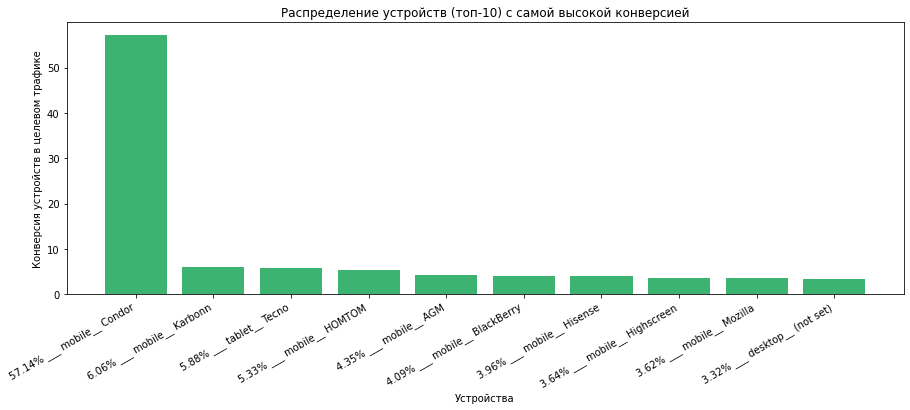

In [110]:
top_device_target_CR = device_target_CR.iloc[0:10]
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(top_device_target_CR['CR_device'], top_device_target_CR['CR'], color=['mediumseagreen'])
plt.xlabel('Устройства')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Конверсия устройств в целевом трафике')
plt.title('Распределение устройств (топ-10) с самой высокой конверсией')

Если не учитывать устройства, с которых был совершен лишь 1 визит, то самый высокий показатель **CR** в целевые действия имеет мобильное устройство  **`Condor`**, CR котрого равен **57.14%**.
Значимыми же было решено считать показатели тех устройств, посредством которых было совершено `более 1 целевого действия и CR > 2.5%`.

### 4.1.4 Из каких локаций идёт самый целевой трафик?

### `Локации в общем трафике`

In [111]:
geo_month = df.groupby(['month', 'geo_city', 'geo_country'], as_index=False).agg({'target_session':['sum','count']})
                   
geo_month.columns = ['_'.join(col).rstrip('_') for col in geo_month.columns.values]
geo_month = geo_month.rename(columns={'target_session_sum':'target_sessions','target_session_count':'all_sessions'})                                                 
                                                  
geo_month['CR'] = geo_month['target_sessions'] / geo_month['all_sessions']
print('Обобщенные данные о локациях по месяцам:')
geo_month.head()

Обобщенные данные о локациях по месяцам:


month   geo_city geo_country  target_sessions  all_sessions        CR
0    5.0  (not set)   (not set)                4           106  0.037736
1    5.0  (not set)     Armenia                0             1  0.000000
2    5.0  (not set)     Bahrain                0             1  0.000000
3    5.0  (not set)  Bangladesh                0             9  0.000000
4    5.0  (not set)     Belarus                0             3  0.000000

In [112]:
total_all_geo = geo_month.all_sessions.sum()
geo_all_m = geo_month.sort_values(by=['all_sessions'], ascending=False)
geo_all_m['%'] = round(geo_all_m['all_sessions'] * 100 / total_all_geo)
all_geo_m = geo_all_m.sort_values(by=['month', 'all_sessions'], ascending=False)
all_geo_m = geo_all_m.groupby(['month'], as_index=False). \
                      agg('first')[['month','geo_city', 'geo_country', 'CR', '%']]
all_geo_m

month geo_city geo_country        CR    %
0    5.0   Moscow      Russia  0.061771  3.0
1    6.0   Moscow      Russia  0.044695  4.0
2    7.0   Moscow      Russia  0.031960  5.0
3    8.0   Moscow      Russia  0.035319  5.0
4    9.0   Moscow      Russia  0.024345  7.0
5   10.0   Moscow      Russia  0.028492  6.0
6   11.0   Moscow      Russia  0.025631  6.0
7   12.0   Moscow      Russia  0.022895  8.0

In [113]:
all_geo_m['month_geo'] = all_geo_m['month'].astype(str) + ' / ' + all_geo_m['geo_city'] + '__' + all_geo_m['geo_country']

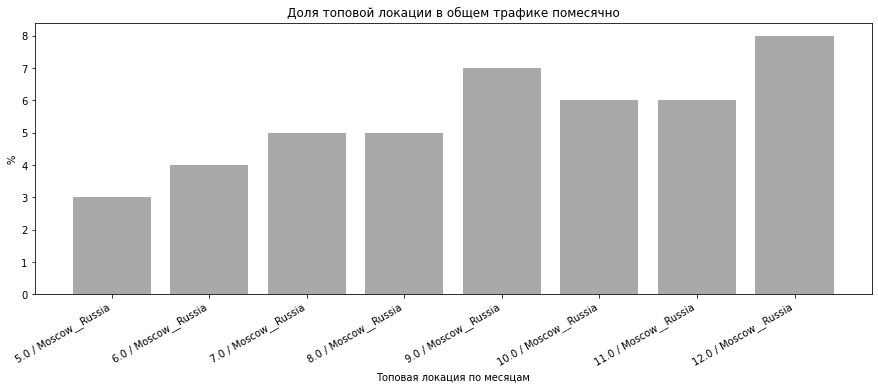

In [114]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(all_geo_m['month_geo'], all_geo_m['%'], color=['darkgrey'])
plt.xlabel('Топовая локация по месяцам')
plt.xticks(ha='right', rotation=30)
plt.ylabel('%')
plt.title('Доля топовой локации в общем трафике помесячно');

In [115]:
geo = df.groupby(['geo_city','geo_country'], as_index=False).agg({'target_session':['sum','count']})
geo.columns = ['_'.join(col).rstrip('_') for col in geo.columns.values]
geo = geo.rename(columns={'target_session_sum':'target_sessions',
                          'target_session_count':'all_sessions'})
geo['CR'] = round(geo['target_sessions'] / geo['all_sessions'] * 100, 2)

In [116]:
all_total_geo = geo.all_sessions.sum()
all_geo = geo.sort_values(by=['all_sessions'], ascending=False)
all_geo['%'] = round(all_geo['all_sessions'] * 100 / all_total_geo, 2)
print('Доля локаций в общем трафике')
all_geo.head(10)

Доля локаций в общем трафике


geo_city geo_country  target_sessions  all_sessions    CR      %
1485            Moscow      Russia            23625        750873  3.15  43.35
1951  Saint Petersburg      Russia             7113        278399  2.55  16.07
91           (not set)      Russia             1361         65755  2.07   3.80
2472     Yekaterinburg      Russia              887         33554  2.64   1.94
1178         Krasnodar      Russia             1081         30260  3.57   1.75
1075             Kazan      Russia             1139         27689  4.11   1.60
1969            Samara      Russia              727         23433  3.10   1.35
1587   Nizhny Novgorod      Russia              559         20781  2.69   1.20
2301               Ufa      Russia              639         20283  3.15   1.17
1625       Novosibirsk      Russia              509         20111  2.53   1.16

In [117]:
all_geo['%_geo'] = all_geo['%'].astype(str) + '% ___ ' + all_geo['geo_city'] + '__' + all_geo['geo_country']
geo_top = all_geo.iloc[0:10]

Text(0.5, 1.0, 'Распределение визитов из топовых локаций (топ-10) в общем трафике')

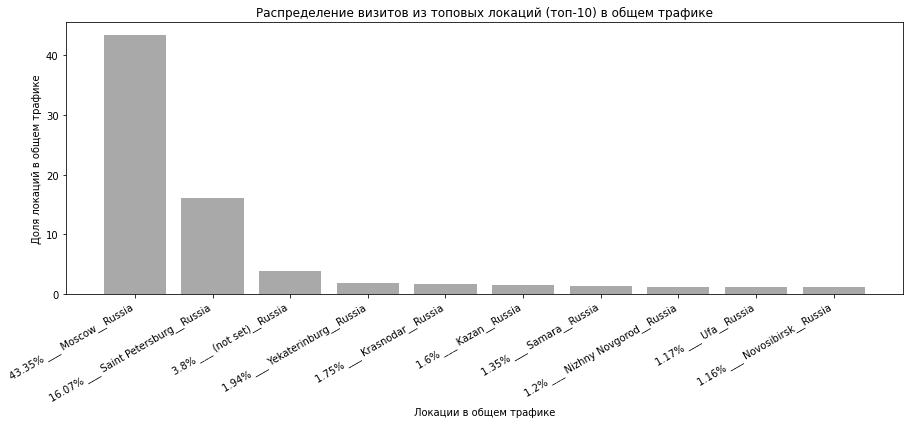

In [118]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(geo_top['%_geo'], geo_top['%'], color=['darkgrey'])
plt.xlabel('Локации в общем трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля локаций в общем трафике')
plt.title('Распределение визитов из топовых локаций (топ-10) в общем трафике')

In [119]:
all_geo['is_geo'] = all_geo['%'].apply(lambda x: 'geo_top' if x > 5.0 else 'other')
top_geo = all_geo.groupby(['is_geo'],as_index=False).agg({'all_sessions':['sum','count']})
top_geo

is_geo all_sessions      
                    sum count
0  geo_top      1029272     2
1    other       702918  2530

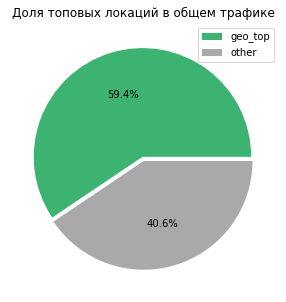

In [120]:
explode = (0.02, 0.02)
colors = ['mediumseagreen','darkgrey']
plt.figure(figsize=(8, 5))
plt.pie(top_geo['all_sessions','sum'], 
        labels=top_geo['is_geo'], labeldistance=None, autopct = '%0.1f%%', colors=colors, explode=explode)
plt.title("Доля топовых локаций в общем трафике")
plt.legend()
plt.show();

**Чаще всего в общем трафике визиты совершались из:**
- ***Москвы*** 

Причем, наблюдаемый на графике восходящий тренд, говорит об устойчивом наборе популярности сервиса в столице.

Кроме ***Москвы***, сервис оказался очень популярен в ***Санкт-Петербурге***. 

- Москва - 43.35%
- Санкт-Петербург - 16,07%

Т.о., на **топовые** локации, доля которых составляет **более `5%`** в **общем трафике**, приходится **`59,4%`**. Причем больше **`43%`** приходится на ***Москву***.

### `Локации в целевом трафике`

In [121]:
total_target_geo = geo_month.target_sessions.sum()
geo_target_m = geo_month.sort_values(by=['target_sessions'], ascending=False)
geo_target_m['%'] = round(geo_target_m['target_sessions'] * 100 / total_target_geo, 2)
target_geo_m = geo_target_m.sort_values(by=['month', 'target_sessions'], ascending=False)
target_geo_m = geo_target_m.groupby(['month'], as_index=False). \
                            agg('first')[['month','geo_city', 'geo_country', 'CR', '%']]
target_geo_m

month geo_city geo_country        CR     %
0    5.0   Moscow      Russia  0.061771  6.62
1    6.0   Moscow      Russia  0.044695  6.60
2    7.0   Moscow      Russia  0.031960  5.12
3    8.0   Moscow      Russia  0.035319  5.56
4    9.0   Moscow      Russia  0.024345  5.79
5   10.0   Moscow      Russia  0.028492  5.43
6   11.0   Moscow      Russia  0.025631  5.47
7   12.0   Moscow      Russia  0.022895  6.37

In [122]:
target_geo_m['month_geo'] = target_geo_m['month'].astype(str) + \
                            ' / ' + target_geo_m['geo_city'] + \
                            '__' + target_geo_m['geo_country']

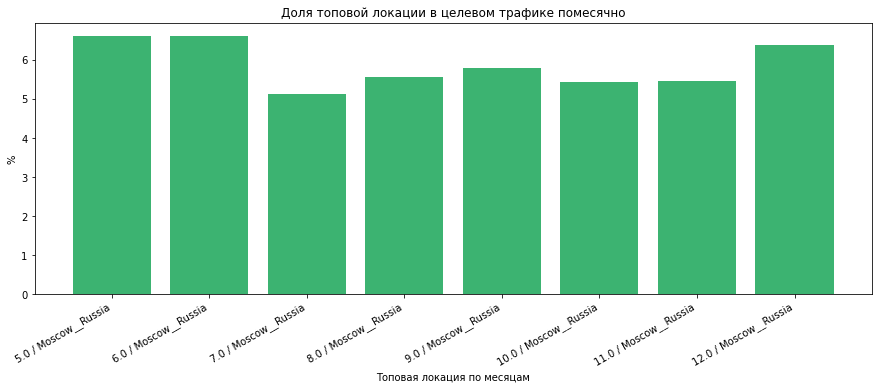

In [123]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(target_geo_m['month_geo'], target_geo_m['%'], color=['mediumseagreen'])
plt.xlabel('Топовая локация по месяцам')
plt.xticks(ha='right', rotation=30)
plt.ylabel('%')
plt.title('Доля топовой локации в целевом трафике помесячно');

In [124]:
total_target_geo = geo.target_sessions.sum()
geo_target = geo.sort_values(by=['target_sessions'], ascending=False)
geo_target['%'] = round(geo_target['target_sessions'] * 100 / total_target_geo, 2)
print('Доля локаций в целевом трафике')
geo_target.head(10)

Доля локаций в целевом трафике


geo_city geo_country  target_sessions  all_sessions    CR      %
1485            Moscow      Russia            23625        750873  3.15  46.96
1951  Saint Petersburg      Russia             7113        278399  2.55  14.14
91           (not set)      Russia             1361         65755  2.07   2.71
1075             Kazan      Russia             1139         27689  4.11   2.26
1178         Krasnodar      Russia             1081         30260  3.57   2.15
2472     Yekaterinburg      Russia              887         33554  2.64   1.76
1969            Samara      Russia              727         23433  3.10   1.45
2301               Ufa      Russia              639         20283  3.15   1.27
1587   Nizhny Novgorod      Russia              559         20781  2.69   1.11
1625       Novosibirsk      Russia              509         20111  2.53   1.01

In [125]:
geo_target['%_geo'] = geo_target['%'].astype(str) + '% ___ ' + geo_target['geo_city'] + '__' + geo_target['geo_country']
geo_target_top = geo_target.iloc[0:10]

Text(0.5, 1.0, 'Распределение визитов из топовых локаций (топ-10) в целевом трафике')

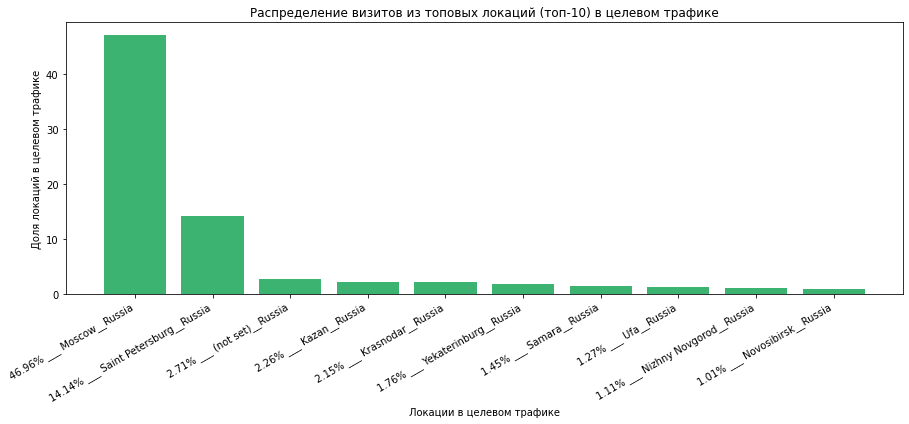

In [126]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(geo_target_top['%_geo'], geo_target_top['%'], color=['mediumseagreen'])
plt.xlabel('Локации в целевом трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля локаций в целевом трафике')
plt.title('Распределение визитов из топовых локаций (топ-10) в целевом трафике')

In [127]:
geo_target['is_geo'] = geo_target['%'].apply(lambda x: 'geo_top' if x > 5.0 else 'other')
geo_top_target= geo_target.groupby(['is_geo'],as_index=False).agg({'target_sessions':['sum','count']})

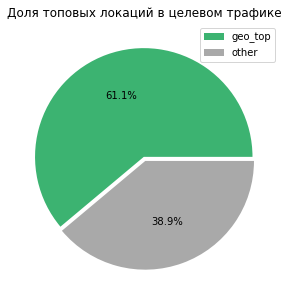

In [128]:
explode = (0.02, 0.02)
colors = ['mediumseagreen','darkgrey']
plt.figure(figsize=(8, 5))
plt.pie(geo_top_target['target_sessions','sum'], 
        labels=geo_top_target['is_geo'], labeldistance=None, autopct = '%0.1f%%', colors=colors, explode=explode)
plt.title("Доля топовых локаций в целевом трафике")
plt.legend()
plt.show();

**Как и в общем трафике, в целевом трфике визиты чаще всего совершались из:**
- ***Москвы*** 

Причем, конверсия в столице устойчиво держится на уровне 5-6% в месячном выражении.

Доля ***Москвы*** в целевом трафике составила **46.96%**.

Вторым по популярности городом в целевом трафике оказался ***Санкт-Петербурге***. Его доля составила **14.14%**

Т.о., на **топовые** локации, доля которых составляет **более `5%`** в **целевом трафике**, приходится **`61,1%`**.

In [129]:
geo.sort_values(by=['CR'], ascending=False).head(10)

geo_city     geo_country  target_sessions  all_sessions  \
1444            Middletown   United States                1             1   
1638                 Nybro          Sweden                1             1   
356           Beaver Falls   United States                1             1   
474                Brescia           Italy                1             1   
2032           Senftenberg         Germany                1             1   
1987  Sandnes Municipality          Norway                1             1   
1932                 Royan          France                1             1   
1921               Rostock         Germany                1             1   
863              Gravesend  United Kingdom                1             1   
1848               Qingdao           China                1             1   

         CR  
1444  100.0  
1638  100.0  
356   100.0  
474   100.0  
2032  100.0  
1987  100.0  
1932  100.0  
1921  100.0  
863   100.0  
1848  100.0

In [130]:
geo_target_CR = geo[(geo.CR > 2.5) & (geo.target_sessions > 1)]. \
                sort_values(by=['CR'], ascending=False).head(10)
geo_target_CR['CR_geo'] = geo_target_CR['CR'].astype(str) + \
                         '% ___ ' + geo_target_CR['geo_city'] + \
                         '__ ' + geo_target_CR['geo_country']

Text(0.5, 1.0, 'Распределение локаций (топ-10) с самой высокой конверсией')

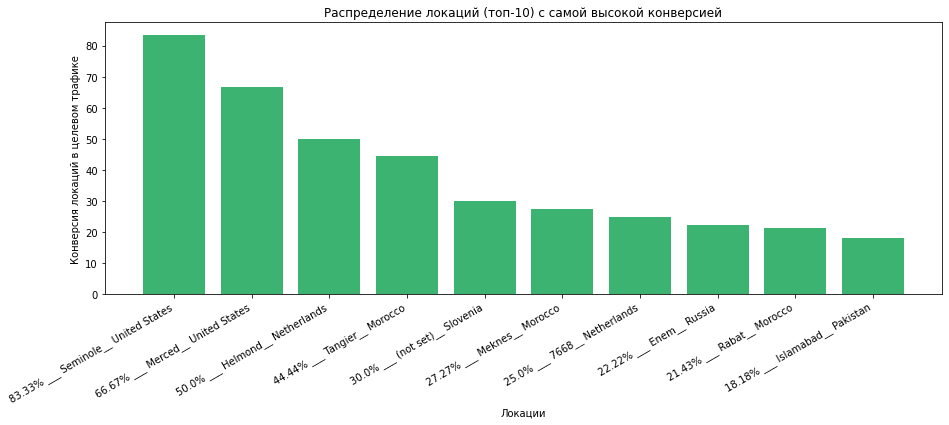

In [131]:
top_geo_target_CR = geo_target_CR.iloc[0:10]
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(top_geo_target_CR['CR_geo'], top_geo_target_CR['CR'], color=['mediumseagreen'])
plt.xlabel('Локации')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Конверсия локаций в целевом трафике')
plt.title('Распределение локаций (топ-10) с самой высокой конверсией')

Топ локаций по конверсии выглядит непоказательным, поскольку локации с конверсией **> 3%** в среднем дают ***не более 2 целевых сессий***.

Поэтому, если не учитывать локации, из которых был совершен лишь 1 визит, топ 5 по показателю **CR** в целевые действия таков:
- Seminole (United States) - 83,33%
- Merced (United States) - 66,67%
- Helmond (Netherlands) - 50%
- Tangier (Morocco) - 44,44%
- (Slovenia) - 30%


## 4.2. Какие авто пользуются наибольшим спросом? У каких авто самый лучший показатель CR (Conversion Rate) в целевые события?

In [3]:
auto = pd.read_csv('data/ga_auto.csv')
auto.head(2)

session_id    hit_date       brand    model  \
0  7750352294969115059.1640271109.1640271109  2021-12-23        fiat  unknown   
1   885342191847998240.1640235807.1640235807  2021-12-23  volkswagen     polo   

   target_actions  
0               0  
1               0

In [133]:
auto_all = auto.groupby(['brand','model'], as_index=False). \
                agg({'target_actions':'count'})
auto_all = auto_all.sort_values(by=['target_actions'], ascending=False)

In [134]:
auto_all['brand_model'] = auto_all['brand'] + ' ___ ' + auto_all['model']
auto_all_top = auto_all.iloc[0:10]

Text(0.5, 1.0, 'Распределение марок и моделей авто (топ-10)')

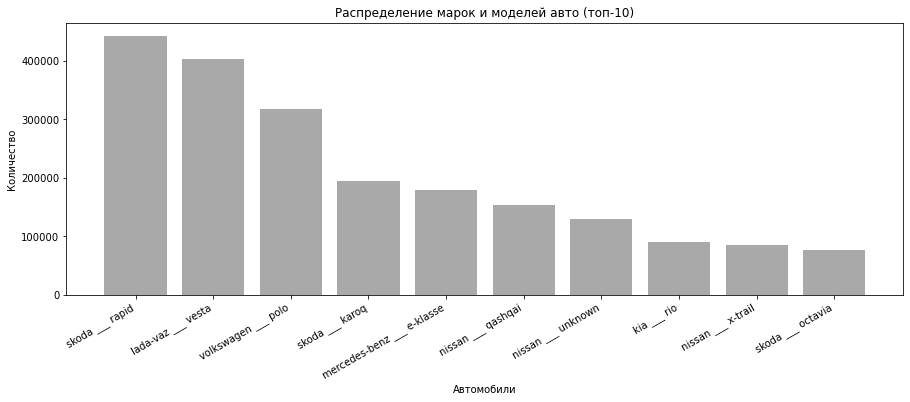

In [135]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(auto_all_top['brand_model'], auto_all_top['target_actions'], color=['darkgrey'])
plt.xlabel('Автомобили')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Количество')
plt.title('Распределение марок и моделей авто (топ-10)')

In [136]:
auto_brand = auto.groupby(['brand'], as_index=False). \
                  agg({'target_actions':'count'})
auto_brand = auto_brand.sort_values(by=['target_actions'], ascending=False)
auto_brand_top = auto_brand.iloc[0:10]

Text(0.5, 1.0, 'Распределение марок авто (топ-10)')

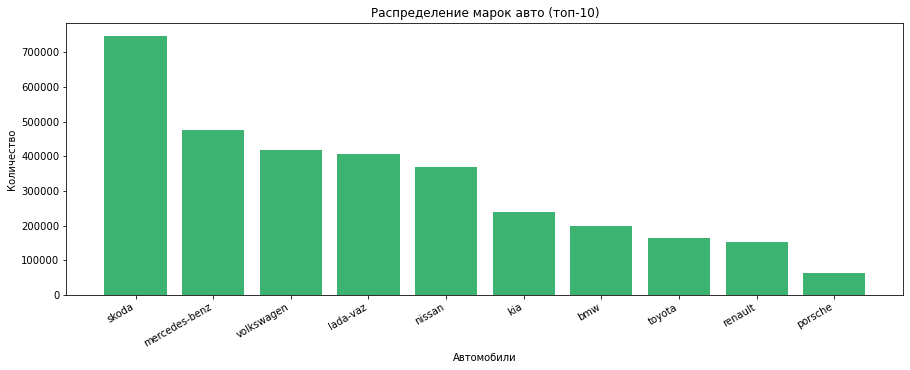

In [137]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(auto_brand_top['brand'], auto_brand_top['target_actions'], color=['mediumseagreen'])
plt.xlabel('Автомобили')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Количество')
plt.title('Распределение марок авто (топ-10)')

**больше всего действий было совершено с авто**                  
- skoda-rapid - 442683                                           
- lada-vesta - 404060
- volkswagen-polo - 318193
- skoda-karoq - 194316
- mercedes-benz-e-klasse - 78647

Если рассматривать количество действий только с учетом **марки авто**, то самыми просматриваемыми были:
- skoda	- 746942
- mercedes-benz	- 475104
- volkswagen	- 419157
- lada-vaz	- 406831
- nissan	- 368738

In [138]:
brand_model_session = auto.groupby(['session_id', 'brand', 'model'], as_index=False). \
                           agg({'target_actions':'sum'})
brand_model_session['target_session'] = brand_model_session.target_actions.apply(lambda x: 1 if x > 0 else 0)
brand_model_session = brand_model_session.groupby(['brand', 'model'], as_index=False) \
                                         .agg({'session_id':'count', 'target_session':'sum'}) \
                                         .rename(columns={'target_session':'target_sessions', 
                                                          'session_id':'all_sessions'})
brand_model_session['CR'] = round(brand_model_session['target_sessions'] / brand_model_session['all_sessions'] * 100, 2) 

In [139]:
total_all = brand_model_session.all_sessions.sum()
auto_all = brand_model_session.sort_values(by=['all_sessions'], ascending=False)
auto_all['%'] = round(auto_all['all_sessions']  / total_all * 100, 2)
auto_all.head(5)

brand     model  all_sessions  target_sessions    CR      %
291          skoda     rapid         56883             2659  4.67  11.99
180       lada-vaz     vesta         49431             2457  4.97  10.42
337     volkswagen      polo         41318             2118  5.13   8.71
288          skoda     karoq         25539              619  2.42   5.38
212  mercedes-benz  e-klasse         22695              553  2.44   4.78

In [140]:
auto_all['CR_auto'] = auto_all['CR'].astype(str) + '% ___ ' + auto_all['brand'] + '__' + auto_all['model']
auto_all = auto_all.iloc[0:10]

Text(0.5, 1.0, 'Топ-10 автомобилей по количеству сессий в общем трафике')

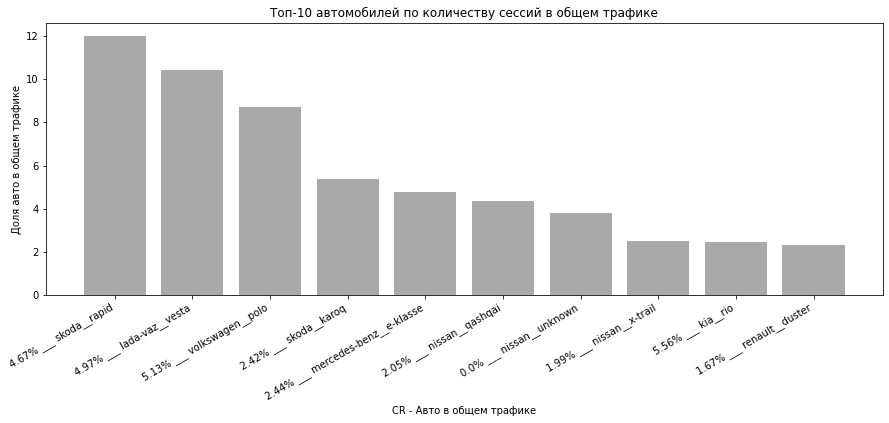

In [141]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(auto_all['CR_auto'], auto_all['%'], color=['darkgrey'])
plt.xlabel('CR - Авто в общем трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля авто в общем трафике')
plt.title('Топ-10 автомобилей по количеству сессий в общем трафике')

In [142]:
brand_session = auto.groupby(['session_id', 'brand'], as_index=False).agg({'target_actions':'sum'})
brand_session['target_session'] = brand_session.target_actions.apply(lambda x: 1 if x > 0 else 0)
brand_session = brand_session.groupby(['brand'], as_index=False) \
                            .agg({'session_id':'count', 
                                  'target_session':'sum'}) \
                            .rename(columns={'target_session':'target_sessions', 
                                             'session_id':'all_sessions'})
brand_session['CR'] = round(brand_session['target_sessions'] / brand_session['all_sessions'] * 100, 2) 
brand_session.head(2)

brand  all_sessions  target_sessions   CR
0       acura            20                0  0.0
1  alfa-romeo            15                0  0.0

In [143]:
total_brand = brand_session.all_sessions.sum()
brand_all = brand_session.sort_values(by=['all_sessions'], ascending=False)
brand_all['%'] = round(brand_all['all_sessions']  / total_brand * 100, 2)
brand_all.head(5)

brand  all_sessions  target_sessions    CR      %
69          skoda         88924             3668  4.12  20.44
77     volkswagen         53210             2315  4.35  12.23
54  mercedes-benz         52670             1081  2.05  12.11
46       lada-vaz         49736             2460  4.95  11.43
57         nissan         43487              653  1.50  10.00

In [144]:
brand_all['CR_brand'] = brand_all['CR'].astype(str) + '% ___ ' + brand_all['brand']
brand_all = brand_all.iloc[0:10]

Text(0.5, 1.0, 'Топ-10 марок автомобилей по количеству сессий в общем трафике')

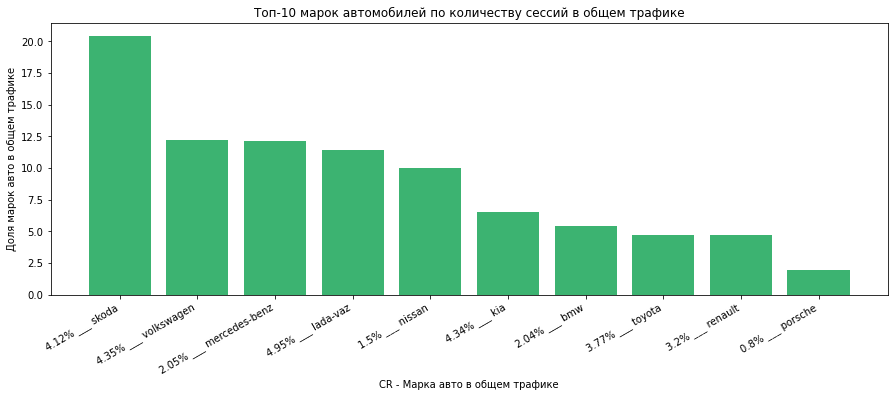

In [145]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(brand_all['CR_brand'], brand_all['%'], color=['mediumseagreen'])
plt.xlabel('CR - Марка авто в общем трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля марок авто в общем трафике')
plt.title('Топ-10 марок автомобилей по количеству сессий в общем трафике')

### С точки зрения ***общего трафика*** 
самыми востребованными были 
- skoda	rapid	с CR = 4.67% и долей 11.99 %
- lada vesta	с CR = 4.97% и долей 10.42 %
- volkswagen polo с CR = 5.13% и долей  8.71%

При этом доля **`skoda`**, как марки, в ***общем трафике*** составила больше **20%** , а конвесия - **4,12%**. В то же время самая высокая конверсия у **`lada-vaz`** - **4.95%** с долей в ***общем трафике*** **11,43%**.

In [146]:
total_target = brand_model_session.target_sessions.sum()
auto_target = brand_model_session.sort_values(by=['target_sessions'], ascending=False)
auto_target['%'] = round(auto_target['target_sessions']  / total_target * 100, 2)
auto_target.head(5)

brand  model  all_sessions  target_sessions    CR      %
291       skoda  rapid         56883             2659  4.67  18.59
180    lada-vaz  vesta         49431             2457  4.97  17.18
337  volkswagen   polo         41318             2118  5.13  14.81
156         kia    rio         11583              644  5.56   4.50
288       skoda  karoq         25539              619  2.42   4.33

In [147]:
auto_target['CR_auto'] = auto_target['CR'].astype(str) + \
                        '% ___ ' + auto_target['brand'] + \
                        '__' + auto_target['model']
auto_target = auto_target.iloc[0:10]

Text(0.5, 1.0, 'Топ-10 автомобилей по количеству сессий в целевом трафике')

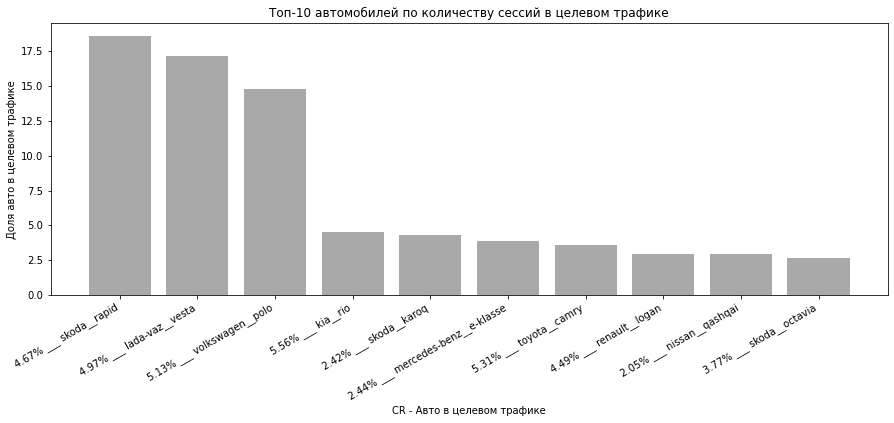

In [148]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(auto_target['CR_auto'], auto_target['%'], color=['darkgrey'])
plt.xlabel('CR - Авто в целевом трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля авто в целевом трафике')
plt.title('Топ-10 автомобилей по количеству сессий в целевом трафике')

In [149]:
target_brand = brand_session.target_sessions.sum()
brand_target = brand_session.sort_values(by=['target_sessions'], ascending=False)
brand_target['%'] = round(brand_target['target_sessions']  / target_brand * 100, 2)
brand_target.head(5)

brand  all_sessions  target_sessions    CR      %
69          skoda         88924             3668  4.12  25.80
46       lada-vaz         49736             2460  4.95  17.30
77     volkswagen         53210             2315  4.35  16.28
45            kia         28478             1235  4.34   8.69
54  mercedes-benz         52670             1081  2.05   7.60

In [150]:
brand_target['CR_brand'] = brand_target['CR'].astype(str) + '% ___ ' + brand_target['brand']
brand_target = brand_target.iloc[0:10]

Text(0.5, 1.0, 'Топ-10 марок автомобилей по количеству сессий в целевом трафике')

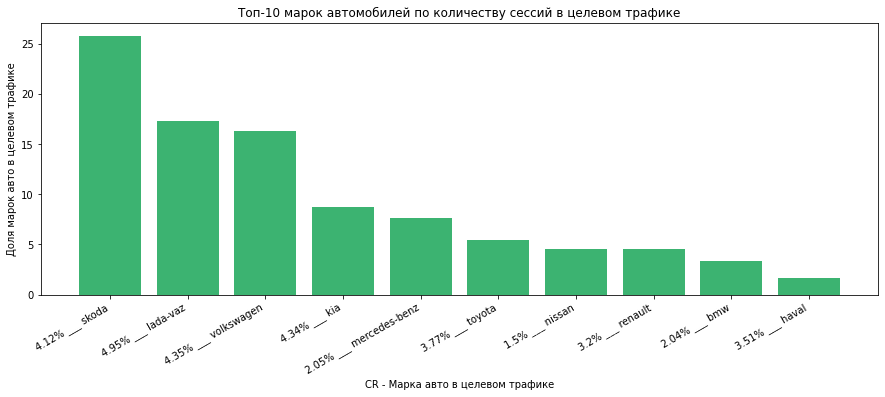

In [151]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(brand_target['CR_brand'], brand_target['%'], color=['mediumseagreen'])
plt.xlabel('CR - Марка авто в целевом трафике')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Доля марок авто в целевом трафике')
plt.title('Топ-10 марок автомобилей по количеству сессий в целевом трафике')

### С точки зрения ***целевого трафика*** 

самыми востребованными были 
- skoda	rapid	с CR = 4.67% и долей 18.59 %
- lada vesta	с CR = 4.97% и долей 17.18 %
- volkswagen polo с CR = 5.13% и долей  14.81%
- kia	rio с CR = 5.56% и долей  4.5%

При этом доля **`skoda`**, как марки, в ***целевом трафике*** составила почти **26%** , а конвесия - **4.12%**. В то же время самая высокая конверсия у **`lada-vaz`** - **4.95%** с долей в ***общем трафике*** **17.3%**.

In [152]:
brand_session.sort_values(by=['CR'], ascending=False).head(10)

brand  all_sessions  target_sessions      CR
36      hawtai             1                1  100.00
70       smart             2                1   50.00
40    infiniti            28                4   14.29
37       honda            65                6    9.23
74       tesla            14                1    7.14
29         gaz            14                1    7.14
39     hyundai          2455              155    6.31
46    lada-vaz         49736             2460    4.95
77  volkswagen         53210             2315    4.35
45         kia         28478             1235    4.34

In [153]:
brand_target_CR = brand_session[(brand_session.CR > 2.5) & 
                                (brand_session.target_sessions > 0) & 
                                (brand_session.all_sessions > 1)].sort_values(by=['CR'], ascending=False).head(10)
brand_target_CR['CR_brand'] = brand_target_CR['CR'].astype(str) + '% ___ ' + brand_target_CR['brand']

Text(0.5, 1.0, 'Распределение марок авто (топ-10) с самой высокой конверсией')

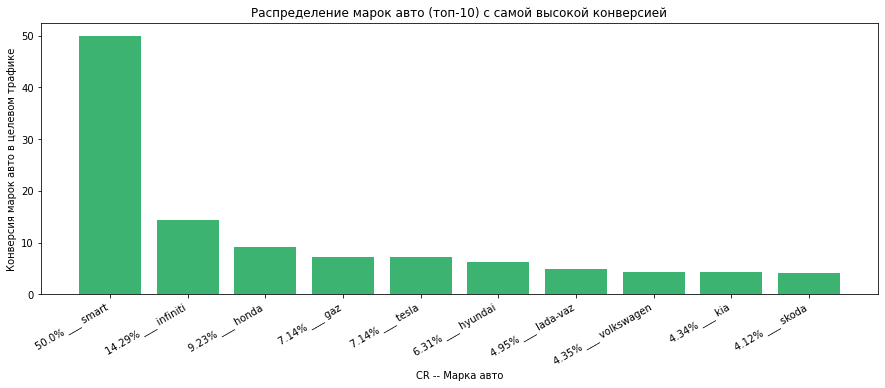

In [154]:
top_brand_target_CR = brand_target_CR.iloc[0:10]
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(top_brand_target_CR['CR_brand'], top_brand_target_CR['CR'], color=['mediumseagreen'])
plt.xlabel('CR -- Марка авто')
plt.xticks(ha='right', rotation=30)
plt.ylabel('Конверсия марок авто в целевом трафике')
plt.title('Распределение марок авто (топ-10) с самой высокой конверсией')

Самый высокий показатель **CR в целевые события** у марки ***`hawtai`*** (100%). Однако, учитывая, что в данном случае **общее количество сессий = целевому трафику = 1**, было решено считать значимыми лишь те марки, где:
  > `были совершены целевые действия`и      
  > `общее количество сессий > 1` и  
  > `CR > 2.5%`. 
  
  Использование этих фильтров позволило выделить топ-5 марок авто с самой высокой конверсией в целевые события.
 
- smart	- 50%
- infiniti	- 14.29%
- honda	 - 9.23%
- tesla	- 7.14 %
- gaz -	7.14%

## 4.3. Стоит ли увеличивать присутствие в соцсетях и давать там больше рекламы?

In [4]:
df.head(2)

session_id  target_session  \
0  1000009318903347362.1632663668.1632663668               0   
1  1000010177899156286.1635013443.1635013443               0   

             utm_source utm_medium          utm_campaign device_category  \
0  MvfHsxITijuriZxsqZqt        cpm  FTjNLDyTrXaWYgZymFkV          mobile   
1  fDLlAcSmythWSCVMvqvL     (none)  LTuZkdKfxRGVceoWkVyg          mobile   

  device_brand geo_country    geo_city  utm_source_social traffic_type  \
0      Samsung      Russia  Gelendzhik                1.0         paid   
1      Samsung      Russia    Voronezh                0.0      organic   

         region  month  
0  Other_Russia    9.0  
1  Other_Russia   10.0

In [5]:
all_net = df.groupby(['utm_source_social'], as_index=False).agg({'target_session':['sum','count']})          
all_net.columns = ['_'.join(col).rstrip('_') for col in all_net.columns.values]
all_net = all_net.rename(columns={'target_session_sum':'target_sessions',
                                  'target_session_count':'all_sessions'})
all_net['reclame'] = all_net['utm_source_social'].apply(lambda x: 'other_media' if x == 0.0 else 'social_media')
all_net = all_net.drop('utm_source_social', axis=1)
all_net['CR'] = round(all_net['target_sessions'] / all_net['all_sessions'] * 100, 1)
print('Обобщенные данные по источникам привлечения:')
all_net

Обобщенные данные по источникам привлечения:


target_sessions  all_sessions       reclame   CR
0            46288       1475910   other_media  3.1
1             4021        256280  social_media  1.6

In [6]:
net_month = df.groupby(['month', 'utm_source'], as_index=False).agg({'target_session':['sum','count'], 
                                                                           'utm_source_social':'first'})
net_month.columns = ['_'.join(col).rstrip('_') for col in net_month.columns.values]
net_month = net_month.rename(columns={'target_session_sum':'target_sessions',
                                      'target_session_count':'all_sessions',
                                      'utm_source_social_first':'reclame'})
net_month['CR'] = round(net_month['target_sessions'] / net_month['all_sessions'] * 100, 1)
net_month['reclame'] = net_month['reclame'].apply(lambda x: 'other_media' if x == 0 else 'social_media')
                                                    
net_month.head(5)

month            utm_source  target_sessions  all_sessions      reclame  \
0    5.0  BHcvLfOaCWvWTykYqHVe              114          1526  other_media   
1    5.0  BKeImrJuRDZcHiSSTdzm               57           410  other_media   
2    5.0  BellrslNBZQZaIxVFGXJ                0             1  other_media   
3    5.0  CgsxHpdTmXHvrHqEKRxp                2            62  other_media   
4    5.0  CtYDKfzJhMZZOyeUeyMX                0             2  other_media   

     CR  
0   7.5  
1  13.9  
2   0.0  
3   3.2  
4   0.0

In [7]:
fig = px.histogram(net_month, labels = {'reclame':'Канал привлечения', 'month':'Месяц'},
                   x = 'month', y = 'all_sessions', 
                   color= 'reclame', barmode = 'group',
                   width = 1000, height = 400,text_auto=True, template = 'plotly_white',
                   color_discrete_map={'other_media': 'darkgrey', 'social_media': 'mediumseagreen'})
fig.update_traces(textposition='outside')
fig.update_layout(yaxis_title_text='Количество сессий', 
                  yaxis_tickformat = '.',title_text='Распределение сессий в общем трафике по месяцам', title_x=0.5)
fig.update_yaxes(range = [0, 330000])    
fig.show()

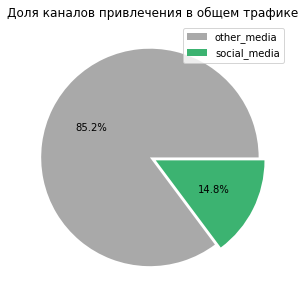

In [8]:
explode = (0.03, 0.03)
colors = ['darkgrey','mediumseagreen']
plt.figure(figsize=(8, 5))
plt.pie(all_net['all_sessions'], 
        labels=all_net['reclame'], labeldistance=None, autopct = '%0.1f%%', colors=colors, explode=explode)
plt.title("Доля каналов привлечения в общем трафике")
plt.legend()
plt.show();

In [9]:
fig = px.histogram(net_month, labels = {'reclame':'Канал привлечения', 'month':'Месяц'},
                   x = 'month', y = 'target_sessions', 
                   color= 'reclame', barmode = 'group',
                   width = 1000, height = 400,text_auto=True, template = 'plotly_white',
                   color_discrete_map={'other_media': 'darkgrey', 'social_media': 'mediumseagreen'})
fig.update_traces(textposition='outside')
fig.update_layout(yaxis_title_text='Количество сессий', 
                  yaxis_tickformat = '.',title_text='Распределение сессий в целевом трафике по месяцам', title_x=0.5)
fig.update_yaxes(range = [0, 6900])    
fig.show()

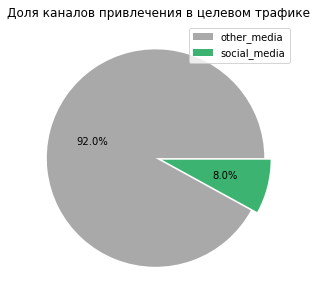

In [10]:
explode = (0.03, 0.03)
colors = ['darkgrey','mediumseagreen']
plt.figure(figsize=(8, 5))
plt.pie(all_net['target_sessions'], 
        labels=all_net['reclame'], labeldistance=None, autopct = '%0.1f%%', colors=colors, explode=explode)
plt.title("Доля каналов привлечения в целевом трафике")
plt.legend()
plt.show();

In [11]:
social_net_m = net_month[net_month['reclame'] == 'social_media']
social_net = social_net_m.groupby(['month', 'reclame'], as_index=False).agg({'all_sessions':['sum'], 
                                                                             'target_sessions': ['sum']})
social_net.columns = ['_'.join(col).rstrip('_') for col in social_net.columns.values]
social_net = social_net.rename(columns={'all_sessions_sum':'all_social',
                                      'target_sessions_sum':'target_social'
                                      })
social_net

month       reclame  all_social  target_social
0    5.0  social_media          16              1
1    6.0  social_media       17457            318
2    7.0  social_media        8160             69
3    8.0  social_media       29552            468
4    9.0  social_media       55789            688
5   10.0  social_media       47317            667
6   11.0  social_media       43320            786
7   12.0  social_media       54669           1024

In [12]:
other_net = net_month[net_month['reclame'] == 'other_media']
other_net = other_net.groupby(['month', 'reclame'], as_index=False).agg({'all_sessions':['sum'], 'target_sessions': ['sum']})
other_net.columns = ['_'.join(col).rstrip('_') for col in other_net.columns.values]
other_net = other_net.rename(columns={'all_sessions_sum':'all_media',
                                      'target_sessions_sum':'target_media'
                                      })
other_net

month      reclame  all_media  target_media
0    5.0  other_media     104575          6427
1    6.0  other_media     143165          6291
2    7.0  other_media     166548          4818
3    8.0  other_media     125451          5030
4    9.0  other_media     188014          5347
5   10.0  other_media     216137          6447
6   11.0  other_media     220476          5655
7   12.0  other_media     311544          6273

In [13]:
df_media = pd.merge(other_net, social_net, how='left', on='month') 

df_media

month    reclame_x  all_media  target_media     reclame_y  all_social  \
0    5.0  other_media     104575          6427  social_media          16   
1    6.0  other_media     143165          6291  social_media       17457   
2    7.0  other_media     166548          4818  social_media        8160   
3    8.0  other_media     125451          5030  social_media       29552   
4    9.0  other_media     188014          5347  social_media       55789   
5   10.0  other_media     216137          6447  social_media       47317   
6   11.0  other_media     220476          5655  social_media       43320   
7   12.0  other_media     311544          6273  social_media       54669   

   target_social  
0              1  
1            318  
2             69  
3            468  
4            688  
5            667  
6            786  
7           1024

In [14]:
df_media['all_media/all_social'] = round(df_media['all_media'] / df_media['all_social'], 2)
df_media['target_media/target_social'] = round(df_media['target_media'] / df_media['target_social'], 2)
df_media[['month', 'all_media/all_social', 'target_media/target_social']]

month  all_media/all_social  target_media/target_social
0    5.0               6535.94                     6427.00
1    6.0                  8.20                       19.78
2    7.0                 20.41                       69.83
3    8.0                  4.25                       10.75
4    9.0                  3.37                        7.77
5   10.0                  4.57                        9.67
6   11.0                  5.09                        7.19
7   12.0                  5.70                        6.13

In [15]:
fig = px.histogram(social_net_m, labels = {'utm_source':'Источник привлечения', 'month':'Месяц'},
                   x = 'month', y = 'target_sessions', 
                   color= 'utm_source', barmode = 'group',
                   width = 1000, height = 400,text_auto=True, template = 'plotly_white',
                   color_discrete_map={'ISrKoXQCxqqYvAZICvjs': 'darkgrey',
                                       'IZEXUFLARCUMynmHNBGo': 'lightblue',
                                       'MvfHsxITijuriZxsqZqt': 'mediumseagreen',
                                       'PlbkrSYoHuZBWfYjYnfw': 'goldenrod',
                                       'QxAxdyPLuQMEcrdZWdWb': 'olive',
                                       'gVRrcxiDQubJiljoTbGm': 'darkkhaki'})
fig.update_traces(textposition='outside')
fig.update_layout(yaxis_title_text='Количество сессий', 
                  yaxis_tickformat = '.',
                  title_text='Распределение по месяцам целевого трафика по источникам из соцсетей', 
                  title_x=0.5)
fig.update_yaxes(range = [0, 600])    
fig.show()

In [16]:
gVRrcxiDQubJiljoTbGm = social_net_m[social_net_m['utm_source'] =='gVRrcxiDQubJiljoTbGm']
MvfHsxITijuriZxsqZqt = social_net_m[social_net_m['utm_source'] =='MvfHsxITijuriZxsqZqt']
PlbkrSYoHuZBWfYjYnfw = social_net_m[social_net_m['utm_source'] =='PlbkrSYoHuZBWfYjYnfw']
QxAxdyPLuQMEcrdZWdWb = social_net_m[social_net_m['utm_source'] =='QxAxdyPLuQMEcrdZWdWb']
ISrKoXQCxqqYvAZICvjs = social_net_m[social_net_m['utm_source'] =='ISrKoXQCxqqYvAZICvjs']
IZEXUFLARCUMynmHNBGo = social_net_m[social_net_m['utm_source'] =='IZEXUFLARCUMynmHNBGo']

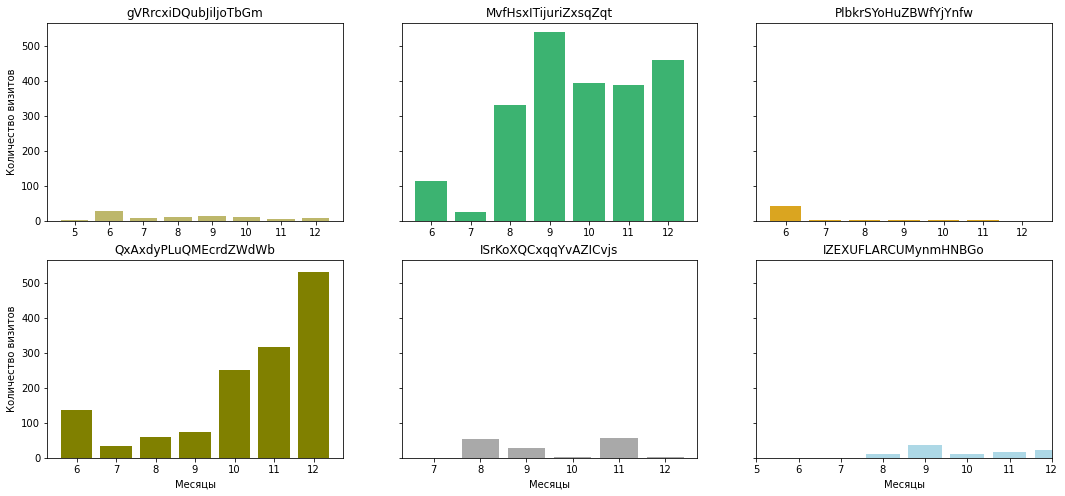

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(18,8), sharey=True )

axs[0, 0].bar(gVRrcxiDQubJiljoTbGm['month'], gVRrcxiDQubJiljoTbGm['target_sessions'], color='darkkhaki')
axs[0, 0].set_ylabel('Количество визитов')
axs[0, 0].set_title('gVRrcxiDQubJiljoTbGm')
axs[0, 1].bar(MvfHsxITijuriZxsqZqt['month'], MvfHsxITijuriZxsqZqt['target_sessions'], color='mediumseagreen')
axs[0, 1].set_title('MvfHsxITijuriZxsqZqt')
axs[0, 2].bar(PlbkrSYoHuZBWfYjYnfw['month'], PlbkrSYoHuZBWfYjYnfw['target_sessions'], color='goldenrod')
axs[0, 2].set_title('PlbkrSYoHuZBWfYjYnfw')
axs[1, 0].bar(QxAxdyPLuQMEcrdZWdWb['month'], QxAxdyPLuQMEcrdZWdWb['target_sessions'], color='olive')
axs[1, 0].set_xlabel('Месяцы')
axs[1, 0].set_ylabel('Количество визитов')
axs[1, 0].set_title('QxAxdyPLuQMEcrdZWdWb')
axs[1, 1].bar(ISrKoXQCxqqYvAZICvjs['month'], ISrKoXQCxqqYvAZICvjs['target_sessions'], color='darkgrey')
axs[1, 1].set_xlabel('Месяцы')
axs[1, 1].set_title('ISrKoXQCxqqYvAZICvjs')
axs[1, 2].bar(IZEXUFLARCUMynmHNBGo['month'], IZEXUFLARCUMynmHNBGo['target_sessions'], color='lightblue')
axs[1, 2].set_xlabel('Месяцы')
axs[1, 2].set_title('IZEXUFLARCUMynmHNBGo')
plt.xlim(5, 12)
plt.show()

In [18]:
fig = px.histogram(social_net_m, labels = {'utm_source':'Источник привлечения', 'month':'Месяц'},
                   x = 'month', y = 'CR', 
                   color= 'utm_source', barmode = 'group',
                   width = 1000, height = 400,text_auto=True, template = 'plotly_white',
                   color_discrete_map={'ISrKoXQCxqqYvAZICvjs': 'darkgrey',
                                       'IZEXUFLARCUMynmHNBGo': 'lightblue',
                                       'MvfHsxITijuriZxsqZqt': 'mediumseagreen',
                                       'PlbkrSYoHuZBWfYjYnfw': 'goldenrod',
                                       'QxAxdyPLuQMEcrdZWdWb': 'olive',
                                       'gVRrcxiDQubJiljoTbGm': 'darkkhaki'})
fig.update_traces(textposition='outside')
fig.update_layout(yaxis_title_text='Конверсия', 
                  yaxis_tickformat = '.',title_text='Распределение конврсии по месяцам целевого трафика по источникам из соцсетей', title_x=0.5)
fig.update_yaxes(range = [0, 20])    
fig.show()

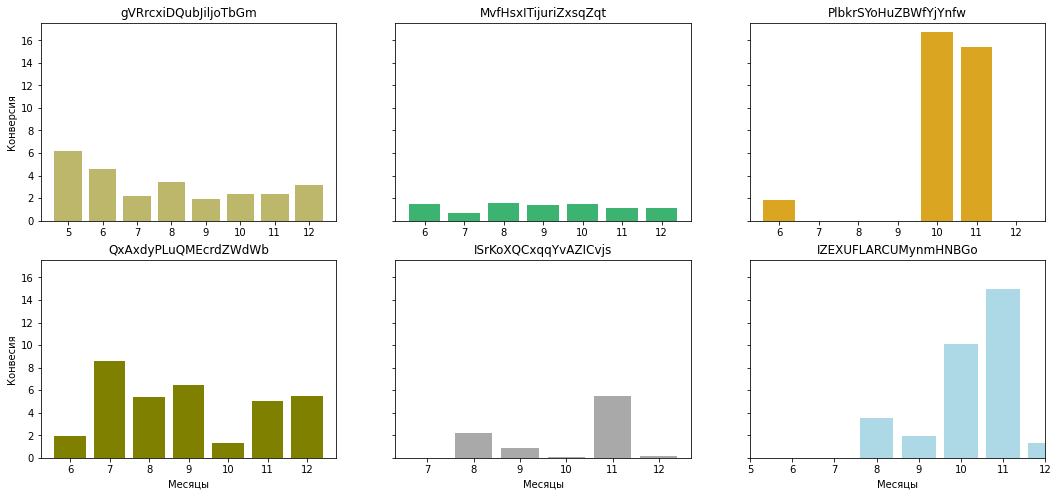

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(18,8), sharey=True )

axs[0, 0].bar(gVRrcxiDQubJiljoTbGm['month'], gVRrcxiDQubJiljoTbGm['CR'], color='darkkhaki')
axs[0, 0].set_ylabel('Конверсия')
axs[0, 0].set_title('gVRrcxiDQubJiljoTbGm')
axs[0, 1].bar(MvfHsxITijuriZxsqZqt['month'], MvfHsxITijuriZxsqZqt['CR'], color='mediumseagreen')
axs[0, 1].set_title('MvfHsxITijuriZxsqZqt')
axs[0, 2].bar(PlbkrSYoHuZBWfYjYnfw['month'], PlbkrSYoHuZBWfYjYnfw['CR'], color='goldenrod')
axs[0, 2].set_title('PlbkrSYoHuZBWfYjYnfw')
axs[1, 0].bar(QxAxdyPLuQMEcrdZWdWb['month'], QxAxdyPLuQMEcrdZWdWb['CR'], color='olive')
axs[1, 0].set_xlabel('Месяцы')
axs[1, 0].set_ylabel('Конвесия')
axs[1, 0].set_title('QxAxdyPLuQMEcrdZWdWb')
axs[1, 1].bar(ISrKoXQCxqqYvAZICvjs['month'], ISrKoXQCxqqYvAZICvjs['CR'], color='darkgrey')
axs[1, 1].set_xlabel('Месяцы')
axs[1, 1].set_title('ISrKoXQCxqqYvAZICvjs')
axs[1, 2].bar(IZEXUFLARCUMynmHNBGo['month'], IZEXUFLARCUMynmHNBGo['CR'], color='lightblue')
axs[1, 2].set_xlabel('Месяцы')
axs[1, 2].set_title('IZEXUFLARCUMynmHNBGo')
plt.xlim(5, 12)
plt.show()

За исследуемый период 
- ***конверсия*** трафика из `соцсетей` составила **1,6%**, что ***ниже*** конверсии из других источников почти в 2 раза;
- **доля трафика** из соцсетей составила около **15%**;
- **Доля целевого трафика** из соцсетей и того меньше - всего **8%**. 

Однако, на графиках распределения сессий по месяцам и общего, и целевого трафика отчетливо отмечается ***положительный тренд*** для канала из соцсетей. Более того, если количество целевых визитов из других источников из месяца в месяц существенно не меняется, то из соцсетей, за последние 5 месяцев 2021г, оно ***возросло более чем в 2 раза***. 

### Следовательно, увеличение рекламы в соцсетях рационально. 

Тем не менее, если дифференцировать источники из соцсетей, то можно увидеть, что ***наилучшие показатели*** у **MvfHsxITijuriZxsqZqt** и **QxAxdyPLuQMEcrdZWdWb**. Количество визитов из остальных соцсетей незначительно мало и не увеличивается, а в некоторых случаях даже падает из месяца в месяц. Поэтому было бы целесообразно усилить рекламу в **MvfHsxITijuriZxsqZqt и QxAxdyPLuQMEcrdZWdWb**. Кроме того, возможно, следует обратить внимание на канал **gVRrcxiDQubJiljoTbGm**. Поскольку, несмотря на относительно небольшое количество визитов, у этого канала стабильно высокие ежемесячные показатели конверсии.